# Previsão de renda

## 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

---

## Etapa 1 CRISP - DM: Entendimento do negócio

Nesse notebook serão analisados os dados de um banco com informações de de clientes de uma instituição financeira. O objetivo final é prever a renda de clientes, com base nas caracteristicas.
Serão realizadas algumas etapas:
- Carregamento dos dados;
- Extruturação desses dados, corrigindo ausencia de valores e outras condições;
-  Determinação de modelos estatísticos de Regressão Linear multipla para predição da renda;
-  Análise de qualidade dos modelos;
-  Implementação e deploy dos dados;

### Dicionário de dados


| Variavel              | Descrição                                             | Tipo      |
|:---------------------:|:-----------------------------------------------------:|:---------:|
|data_ref               | Data de referência de coleta das variáveis            |datetime   |
|index                  | Código de identificação do cliente                    |int64      |
|sexo                   | Sexo do cliente                                       |object     |
|posse_de_veiculo       | Indica se o cliente possui veículo                    |bool       |
|posse_de_imovel        | Indica se o cliente possui imóvel                     |bool       |
|qtd_filhos             | Quantidade de filhos do cliente                       |int64      |
|tipo_renda             | Tipo de renda do cliente                              |object     |
|educacao               | Grau de instrução do cliente                          |object     |
|estado_civil           | Estado civil do cliente                               |object     |
|tipo_residencia        | Tipo de residência do cliente (própria, alugada etc)  |object     |
|idade                  | Idade do cliente                                      |int64      |
|tempo_emprego          | Tempo no emprego atual                                |float64    |
|qt_pessoas_residencia  | Quantidade de pessoas que moram na residência         |float64    |
|renda                  | Renda em reais                                        |float64    |

### Carregando os pacotes

In [18]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from ydata_profiling import ProfileReport

from util import printLis

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from scipy.stats import pearsonr, zscore

from src.functions import *

from joblib import dump
import os

---

## Etapa 2 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?

### Carregando os dados

In [19]:
# Carregando base de dados
link = "https://raw.githubusercontent.com/gfsilveira/ebac/main/"
link += "03-Cientista_de_Dados/02-Crisp_DM/16_modulo/"
link += "projeto_2_resposta/data/previsao_de_renda.csv"
df = pd.read_csv(link)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

### Limpeza dos Dados

In [20]:
# Removendo as colunas que não iremos trabalhar.
df.drop(["Unnamed: 0","id_cliente"], axis=1, inplace=True)

# Removendo dados faltantes
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12427 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data_ref               12427 non-null  object 
 1   sexo                   12427 non-null  object 
 2   posse_de_veiculo       12427 non-null  bool   
 3   posse_de_imovel        12427 non-null  bool   
 4   qtd_filhos             12427 non-null  int64  
 5   tipo_renda             12427 non-null  object 
 6   educacao               12427 non-null  object 
 7   estado_civil           12427 non-null  object 
 8   tipo_residencia        12427 non-null  object 
 9   idade                  12427 non-null  int64  
 10  tempo_emprego          12427 non-null  float64
 11  qt_pessoas_residencia  12427 non-null  float64
 12  renda                  12427 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(6)
memory usage: 1.2+ MB


In [21]:
# Editando os dados de data de referência para datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12427 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               12427 non-null  datetime64[ns]
 1   sexo                   12427 non-null  object        
 2   posse_de_veiculo       12427 non-null  bool          
 3   posse_de_imovel        12427 non-null  bool          
 4   qtd_filhos             12427 non-null  int64         
 5   tipo_renda             12427 non-null  object        
 6   educacao               12427 non-null  object        
 7   estado_civil           12427 non-null  object        
 8   tipo_residencia        12427 non-null  object        
 9   idade                  12427 non-null  int64         
 10  tempo_emprego          12427 non-null  float64       
 11  qt_pessoas_residencia  12427 non-null  float64       
 12  renda                  12427 non-null  float64       
dtypes: boo

In [22]:
# Retirando dados duplicados
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12090 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               12090 non-null  datetime64[ns]
 1   sexo                   12090 non-null  object        
 2   posse_de_veiculo       12090 non-null  bool          
 3   posse_de_imovel        12090 non-null  bool          
 4   qtd_filhos             12090 non-null  int64         
 5   tipo_renda             12090 non-null  object        
 6   educacao               12090 non-null  object        
 7   estado_civil           12090 non-null  object        
 8   tipo_residencia        12090 non-null  object        
 9   idade                  12090 non-null  int64         
 10  tempo_emprego          12090 non-null  float64       
 11  qt_pessoas_residencia  12090 non-null  float64       
 12  renda                  12090 non-null  float64       
dtypes: boo

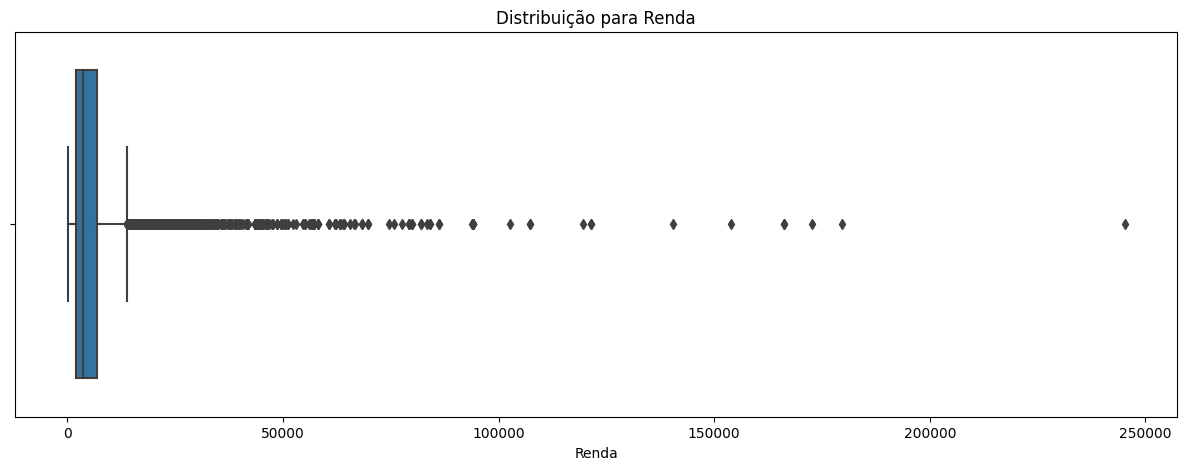

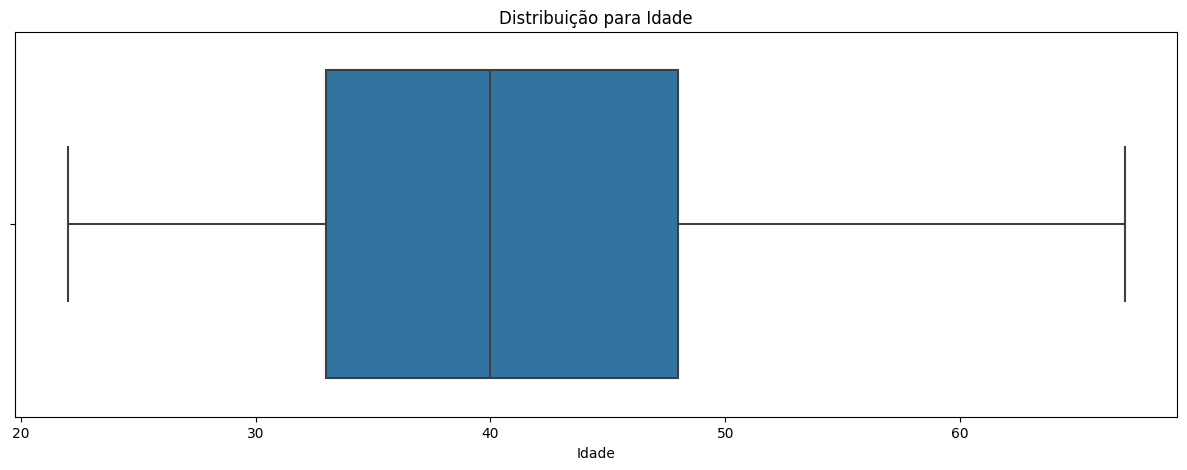

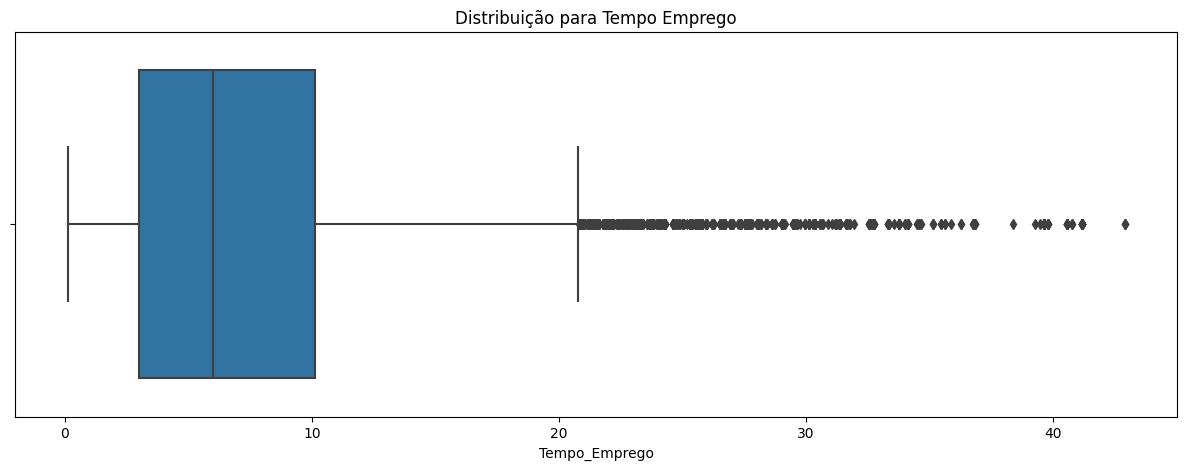

In [23]:
# Analisando a variável depdendente
grafico_boxplot(df=df, coluna="renda")
grafico_boxplot(df=df, coluna="idade")
grafico_boxplot(df=df, coluna="tempo_emprego")

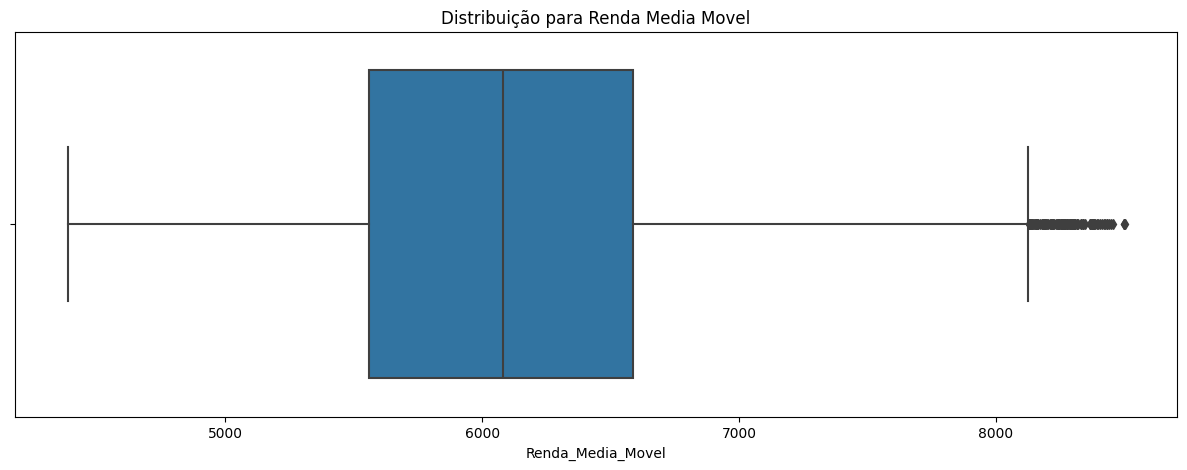

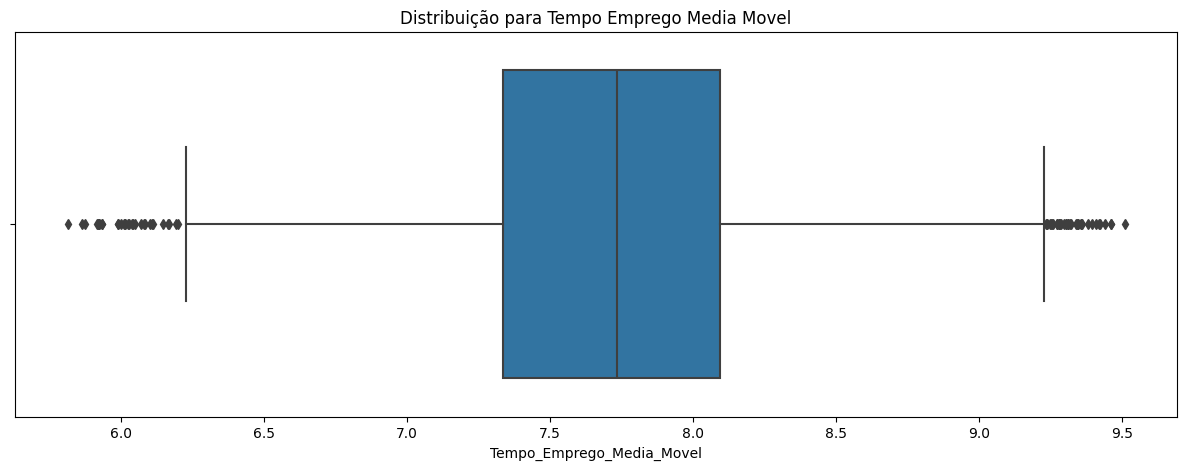

In [24]:
'''
Como a variável dependente renda e tempo de emprego não possuem uma 
distribuição normal, o que pode afetar os modelos que serão usados, obteve-se 
uma segunda variável, usando a média móvel, renda_media_movel e 
tempo_emprego_media_movel, com 1% do número de dados.
'''
media_renda = df['renda'].rolling(len(df) // 100).mean()
df["renda_media_movel"] = media_renda.fillna(media_renda.median())

media_renda = df['tempo_emprego'].rolling(len(df) // 100).mean()
df["tempo_emprego_media_movel"] = media_renda.fillna(media_renda.median())

grafico_boxplot(df=df, coluna="renda_media_movel")
grafico_boxplot(df=df, coluna="tempo_emprego_media_movel")

In [25]:
# Verificando a nova DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12090 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   data_ref                   12090 non-null  datetime64[ns]
 1   sexo                       12090 non-null  object        
 2   posse_de_veiculo           12090 non-null  bool          
 3   posse_de_imovel            12090 non-null  bool          
 4   qtd_filhos                 12090 non-null  int64         
 5   tipo_renda                 12090 non-null  object        
 6   educacao                   12090 non-null  object        
 7   estado_civil               12090 non-null  object        
 8   tipo_residencia            12090 non-null  object        
 9   idade                      12090 non-null  int64         
 10  tempo_emprego              12090 non-null  float64       
 11  qt_pessoas_residencia      12090 non-null  float64       
 12  renda    

In [26]:
'''
As variáveis tipo de residência e estado civil estão significativamente
desbalanceadas, sendo que uma das classes presente em cada uma delas está 
com representação acima de 75%. Nesse caso manteremos apenas os dados 
referêntes à essas classes, removendo as instâncias com as outras informações
'''
filtro = (df['tipo_residencia'] == "Casa") & (df['estado_civil'] == "Casado")
df = df[filtro]
df.drop(labels=['tipo_residencia', 'estado_civil'], axis="columns", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7747 entries, 1 to 14998
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   data_ref                   7747 non-null   datetime64[ns]
 1   sexo                       7747 non-null   object        
 2   posse_de_veiculo           7747 non-null   bool          
 3   posse_de_imovel            7747 non-null   bool          
 4   qtd_filhos                 7747 non-null   int64         
 5   tipo_renda                 7747 non-null   object        
 6   educacao                   7747 non-null   object        
 7   idade                      7747 non-null   int64         
 8   tempo_emprego              7747 non-null   float64       
 9   qt_pessoas_residencia      7747 non-null   float64       
 10  renda                      7747 non-null   float64       
 11  renda_media_movel          7747 non-null   float64       
 12  tempo_empr

In [27]:
# Alterando a classe das variáveis quantidade de filhos e residência para categorias
df[['qtd_filhos',"qt_pessoas_residencia"]] = df[['qtd_filhos',"qt_pessoas_residencia"]].astype("category")

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7747 entries, 1 to 14998
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   data_ref                   7747 non-null   datetime64[ns]
 1   sexo                       7747 non-null   object        
 2   posse_de_veiculo           7747 non-null   bool          
 3   posse_de_imovel            7747 non-null   bool          
 4   qtd_filhos                 7747 non-null   category      
 5   tipo_renda                 7747 non-null   object        
 6   educacao                   7747 non-null   object        
 7   idade                      7747 non-null   int64         
 8   tempo_emprego              7747 non-null   float64       
 9   qt_pessoas_residencia      7747 non-null   category      
 10  renda                      7747 non-null   float64       
 11  renda_media_movel          7747 non-null   float64       
 12  tempo_empr

In [28]:
# Analisando medidas resumo, variáveis quantitativas

df_qualitativas = df.select_dtypes(['category','object','bool']).copy()
df_quantitativas = df.select_dtypes(['float64','int64']).copy()

df_quantitativas.describe()

,idade,tempo_emprego,renda,renda_media_movel,tempo_emprego_media_movel
count,7747.000000,7747.000000,7747.000000,7747.000000,7747.000000
mean,40.901768,7.737004,6448.491748,6105.692070,7.728474
std,9.184346,6.407121,9757.448465,728.758396,0.546041
min,22.000000,0.200000,211.040000,4385.598417,5.813973
25%,33.000000,3.179452,2160.620000,5554.745625,7.336952
50%,40.000000,6.257534,3790.980000,6080.971833,7.736210
75%,48.000000,10.209589,7167.030000,6580.290042,8.094840
max,66.000000,42.906849,179538.800000,8499.385750,9.460662


In [29]:
# Analisando medidas resumo, variáveis qualitativas
df_qualitativas.describe()


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,qt_pessoas_residencia
count,7747,7747,7747,7747,7747,7747,7747.0
unique,2,2,2,6,5,5,7.0
top,F,False,True,0,Assalariado,Secundário,2.0
freq,4698,4137,5322,4655,4840,4457,4655.0


### Salvando o relatório com os dados

In [30]:
# Obtendo o relatório dos dados
prof = ProfileReport(df, explorative=True)
prof.to_file('./output/renda_analisys.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'Superior completo'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Conclusão

- Como a variável dependente `renda` não possuí uma distribuição normal, o que pode afetar os modelos que serão usados, iremos obter uma segunda variável, usando a média móvel, renda_media_movel, com 1% do número de dados.

- As variáveis tipo de residência e estado civil estão significativamente desbalanceadas, sendo que uma das classes presente em cada uma delas está com representação acima de 75%. Nesse caso manteremos apenas os dados referêntes à essas classes, removendo as instâncias com as outras informações

- Alterando a classe das variáveis quantidade de filhos e residência para categorias


### Novo Dicionário de dados


| Variavel                 | Descrição                                             | Tipo      |
|:------------------------:|:-----------------------------------------------------:|:---------:|
|data_ref                  | Data de referência de coleta das variáveis            |datetime   |
|sexo                      | Sexo do cliente                                       |object     |
|posse_de_veiculo          | Indica se o cliente possui veículo                    |bool       |
|posse_de_imovel           | Indica se o cliente possui imóvel                     |bool       |
|qtd_filhos                | Quantidade de filhos do cliente                       |category   |
|tipo_renda                | Tipo de renda do cliente                              |object     |
|educacao                  | Grau de instrução do cliente                          |object     |
|idade                     | Idade do cliente                                      |int64      |
|tempo_emprego             | Tempo no emprego atual                                |float64    |
|qt_pessoas_residencia     | Quantidade de pessoas que moram na residência         |category   |
|renda                     | Renda em reais                                        |float64    |
|renda_media_movel         | Média móvel da Renda em reais                         |float64    |
|tempo_emprego_media_movel | Média móvel da Tempo no emprego atual                 |float64    |

---


## Etapa 3 Crisp-DM: Entendimento dos dados



### Entendimento dos dados - Univariada

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7747 entries, 1 to 14998
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   data_ref                   7747 non-null   datetime64[ns]
 1   sexo                       7747 non-null   object        
 2   posse_de_veiculo           7747 non-null   bool          
 3   posse_de_imovel            7747 non-null   bool          
 4   qtd_filhos                 7747 non-null   category      
 5   tipo_renda                 7747 non-null   object        
 6   educacao                   7747 non-null   object        
 7   idade                      7747 non-null   int64         
 8   tempo_emprego              7747 non-null   float64       
 9   qt_pessoas_residencia      7747 non-null   category      
 10  renda                      7747 non-null   float64       
 11  renda_media_movel          7747 non-null   float64       
 12  tempo_empr

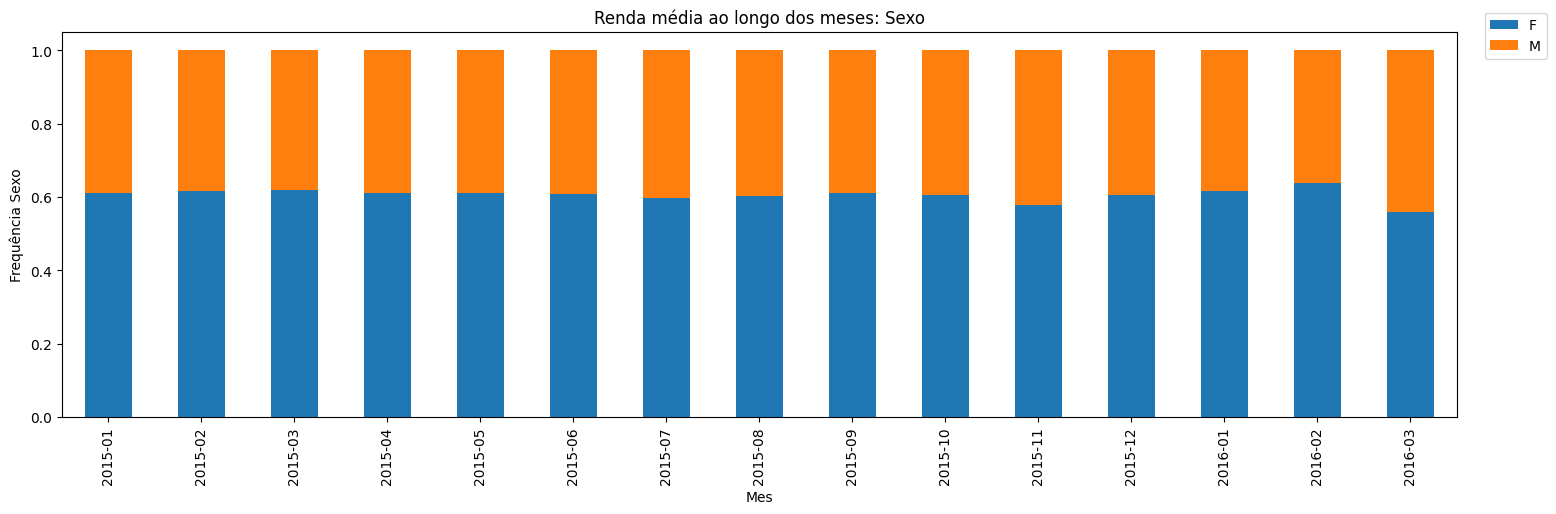

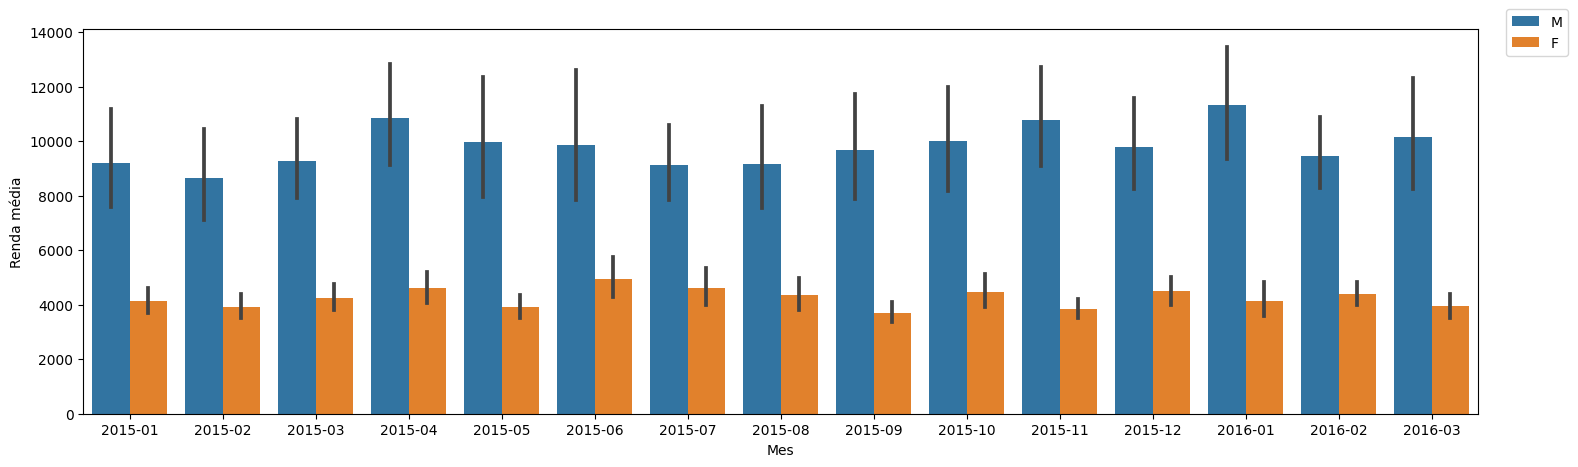

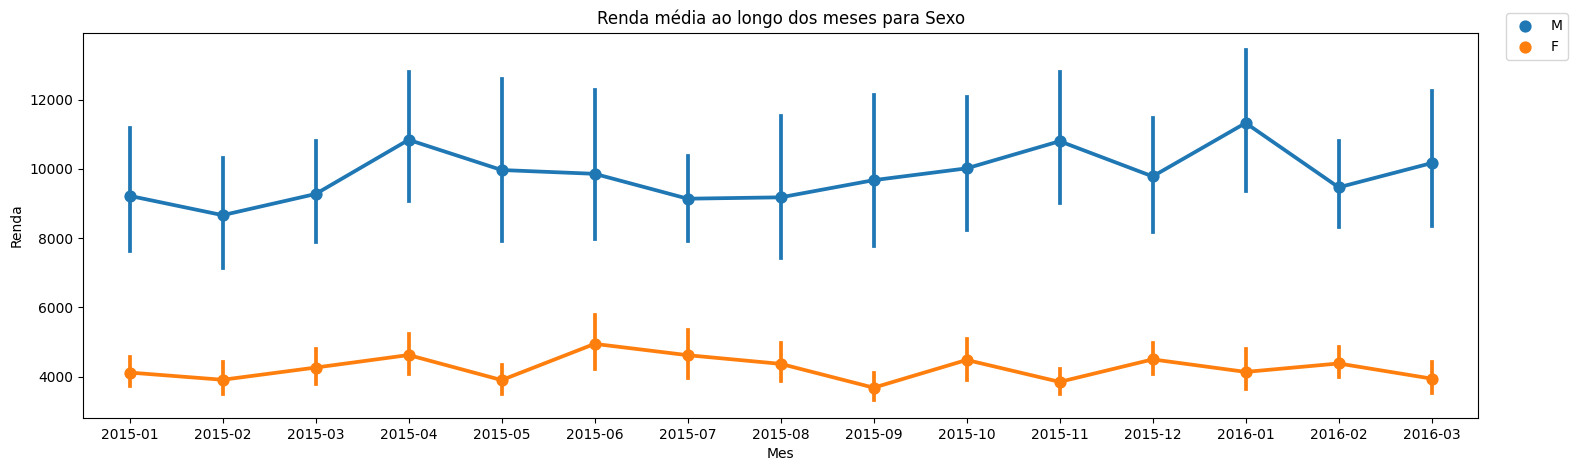

In [32]:
# Verificando variáveis categóricas
coluna = df_qualitativas.columns
c = 0
grafico_barras_stack(df=df, coluna=coluna[c])
grafico_barras(df=df, coluna=coluna[c])
grafico_pontos(df=df, coluna=coluna[c])

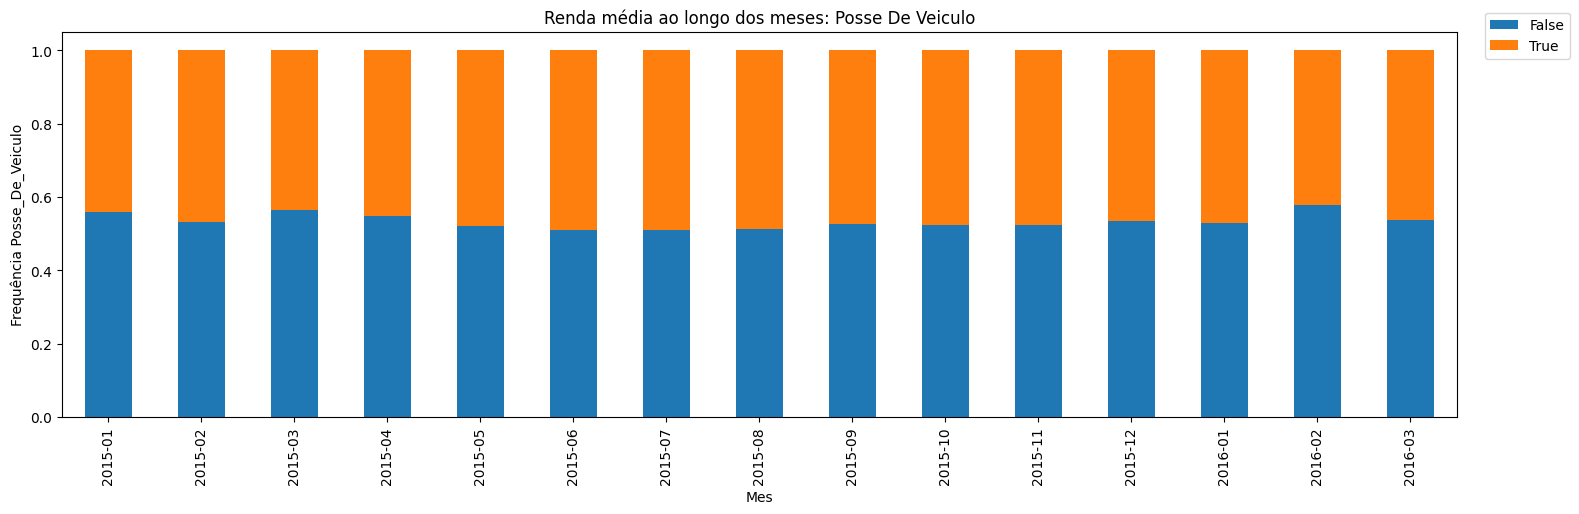

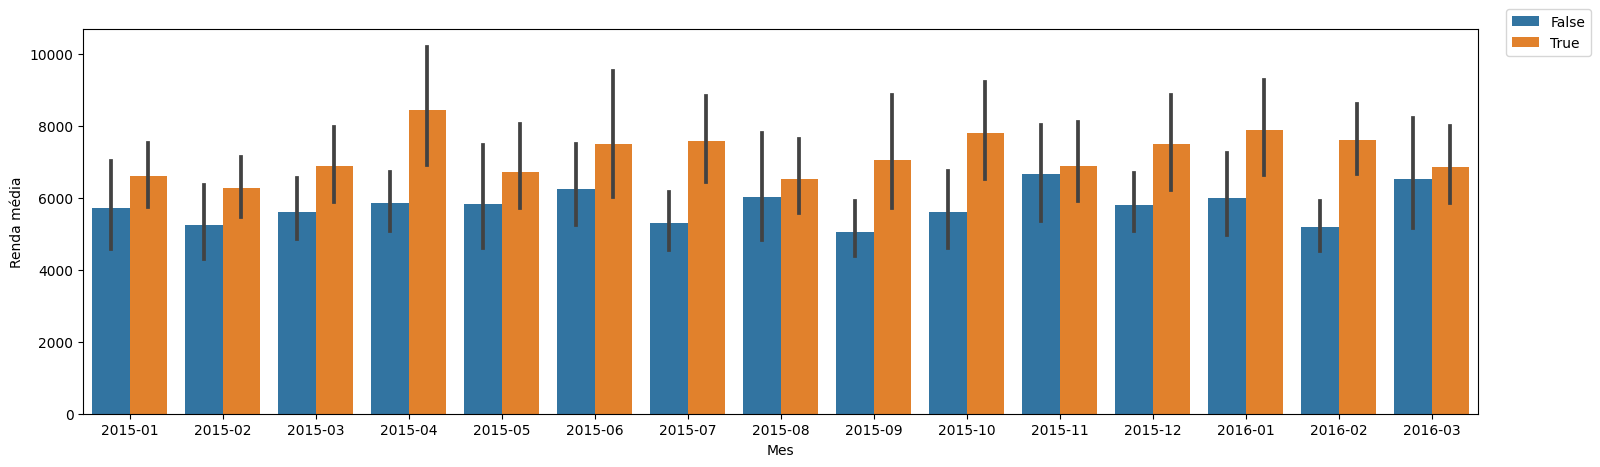

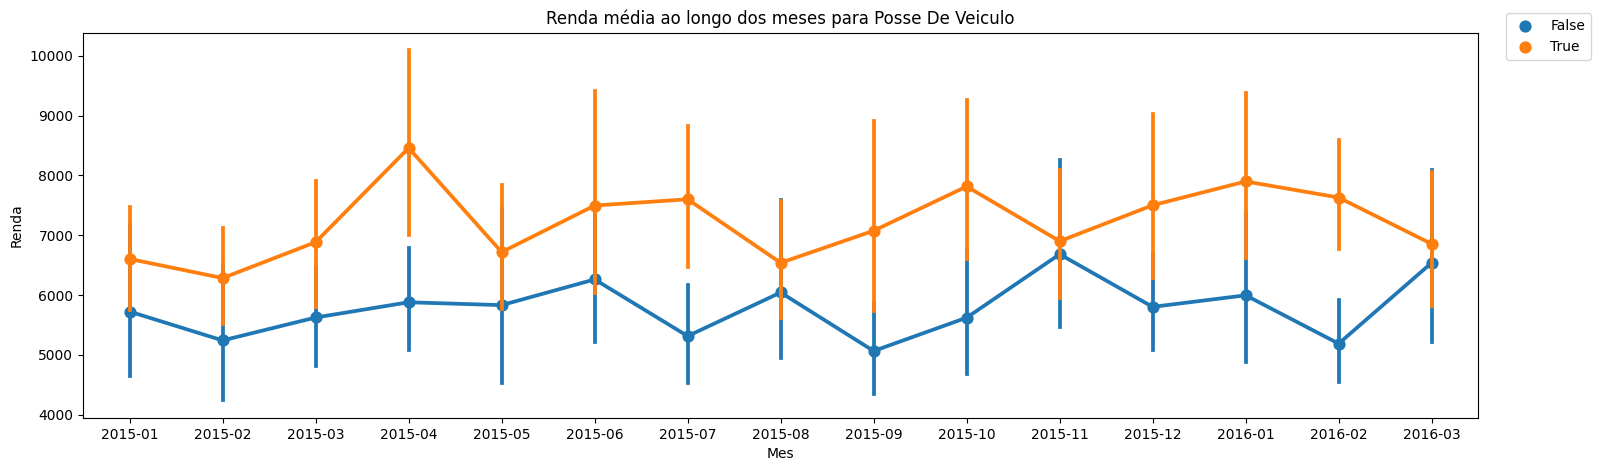

In [33]:
c += 1
grafico_barras_stack(df=df, coluna=coluna[c])
grafico_barras(df=df, coluna=coluna[c])
grafico_pontos(df=df, coluna=coluna[c])

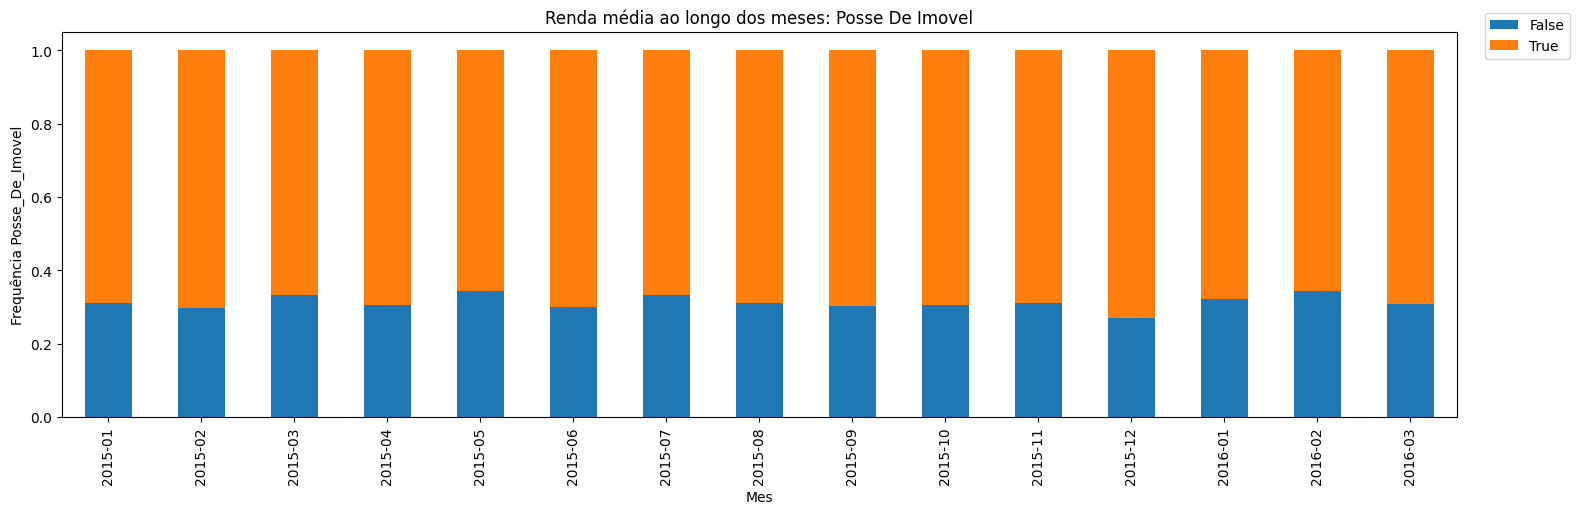

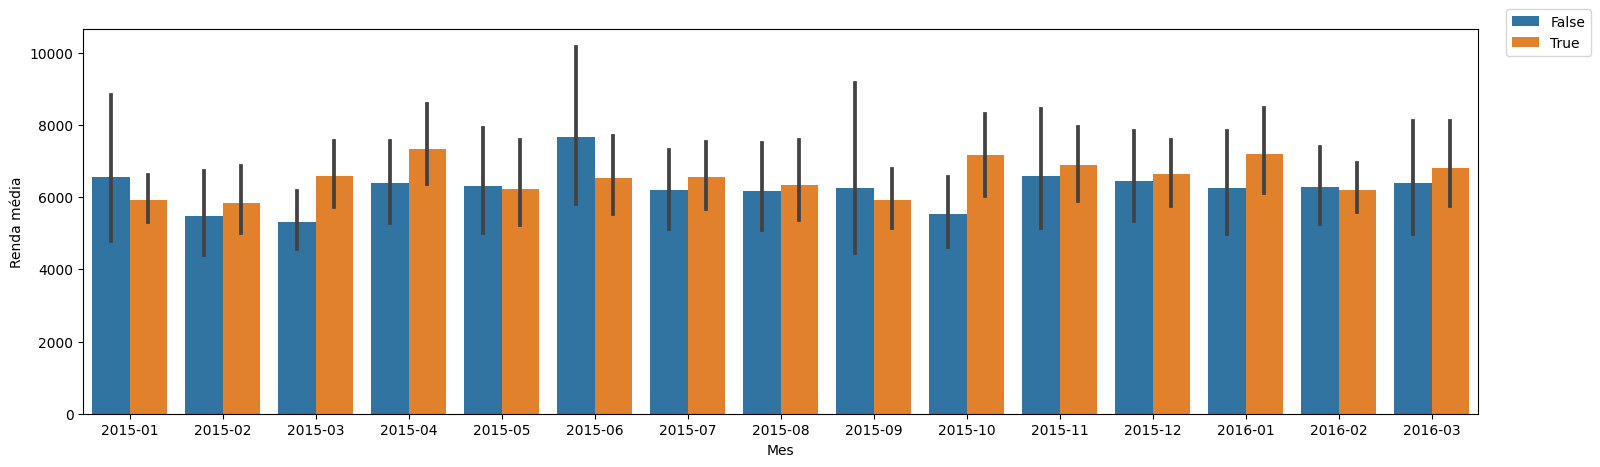

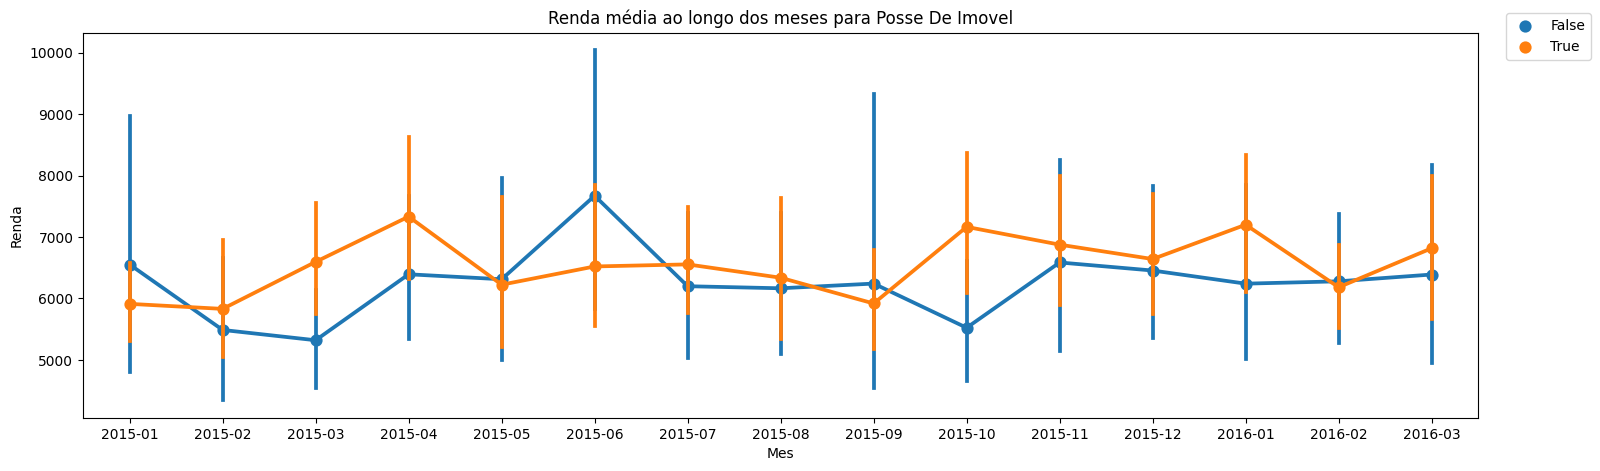

In [34]:
c += 1
grafico_barras_stack(df=df, coluna=coluna[c])
grafico_barras(df=df, coluna=coluna[c])
grafico_pontos(df=df, coluna=coluna[c])

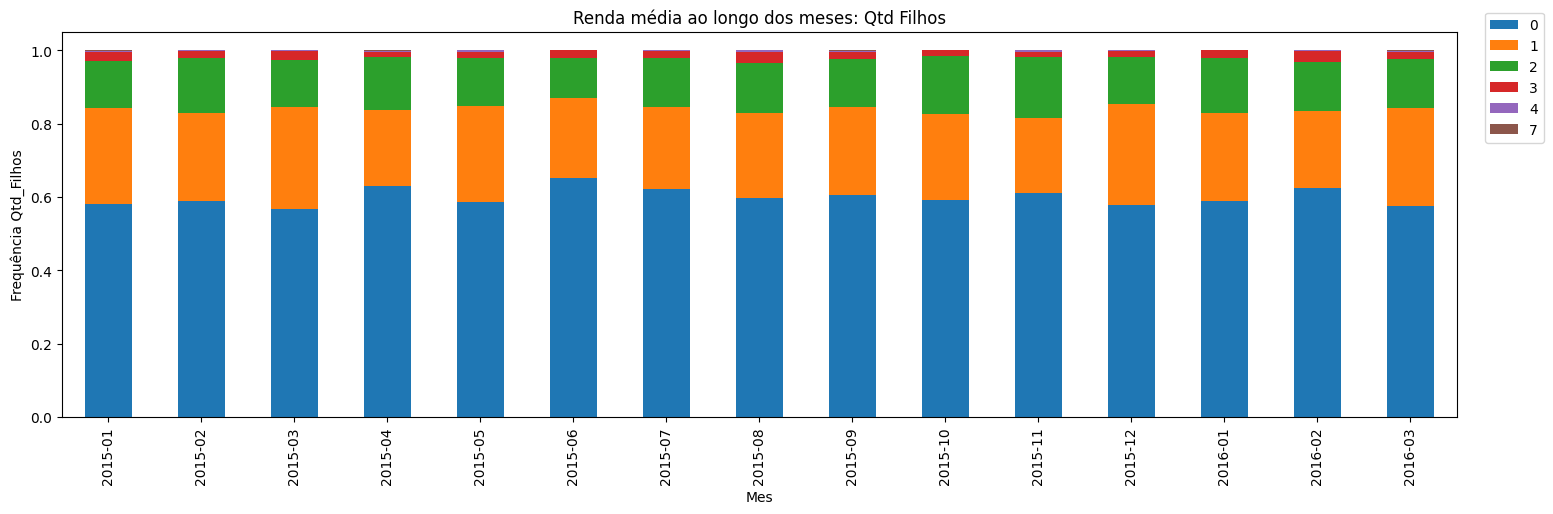

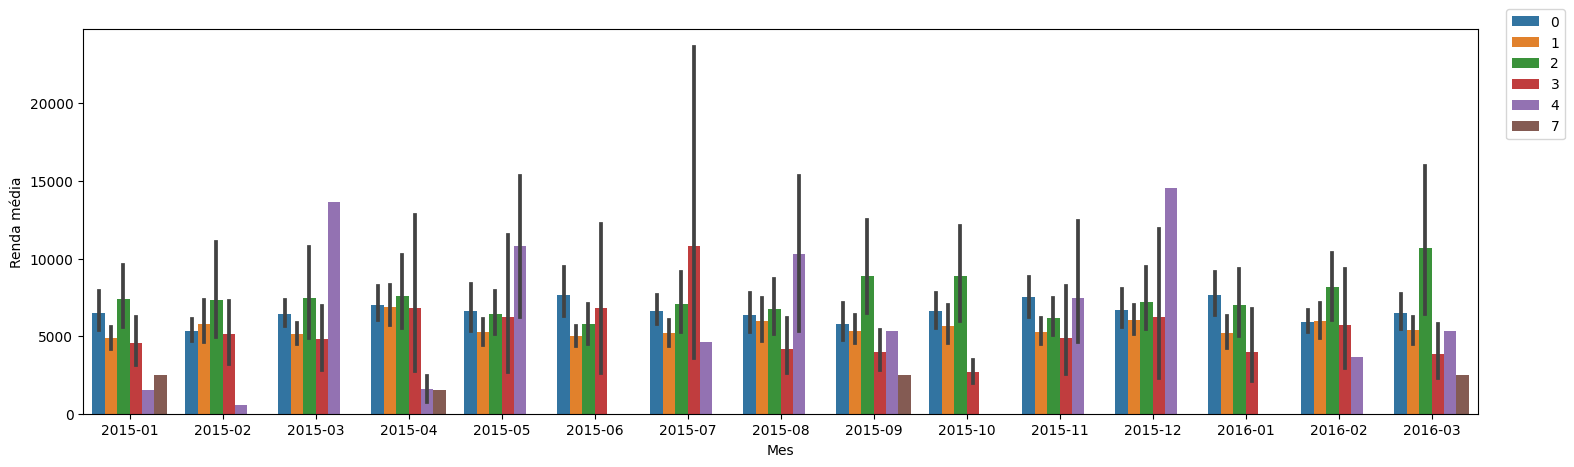

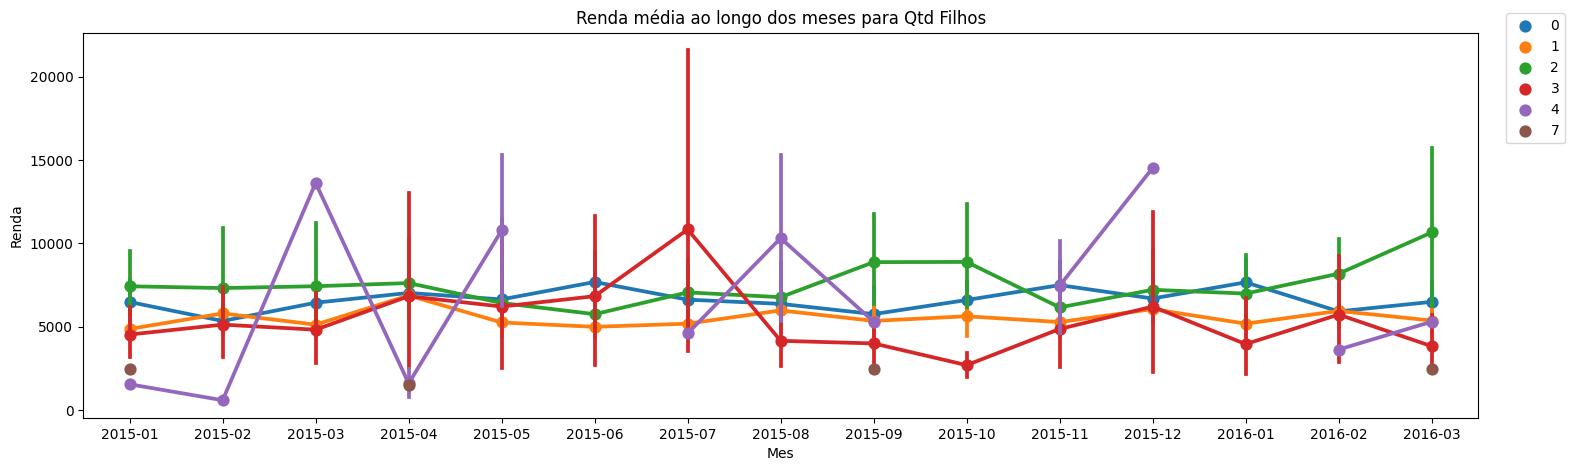

In [35]:
c += 1
grafico_barras_stack(df=df, coluna=coluna[c])
grafico_barras(df=df, coluna=coluna[c])
grafico_pontos(df=df, coluna=coluna[c])

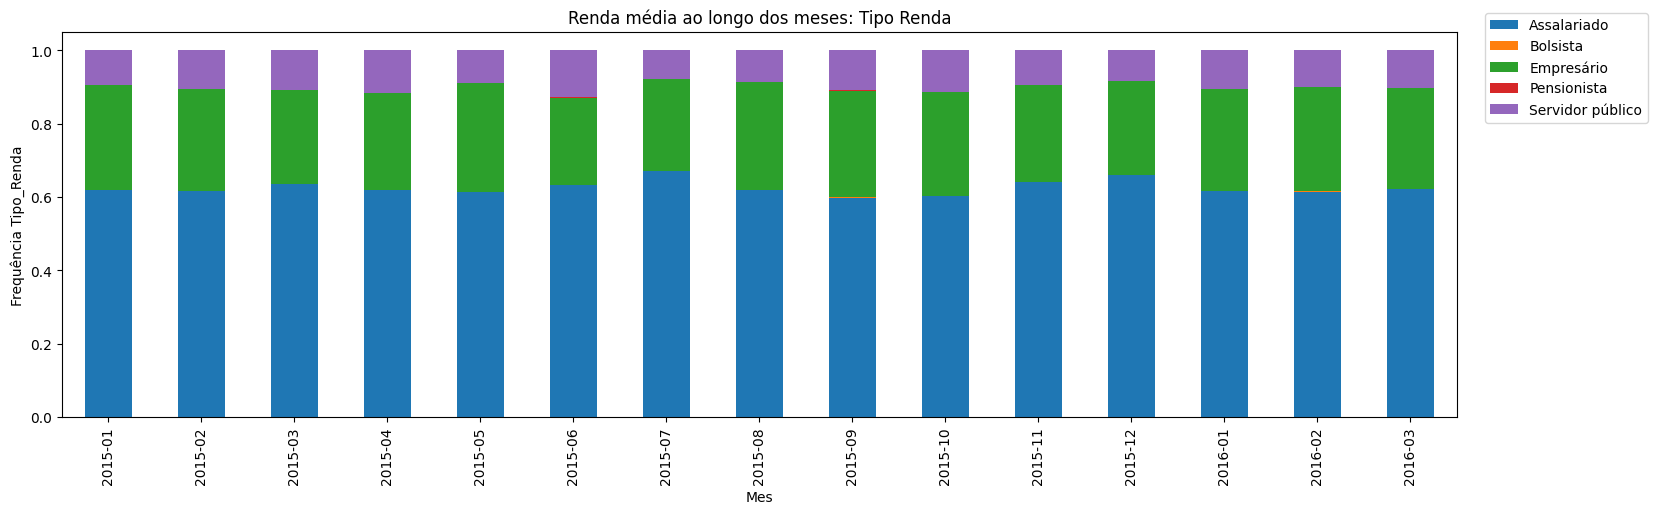

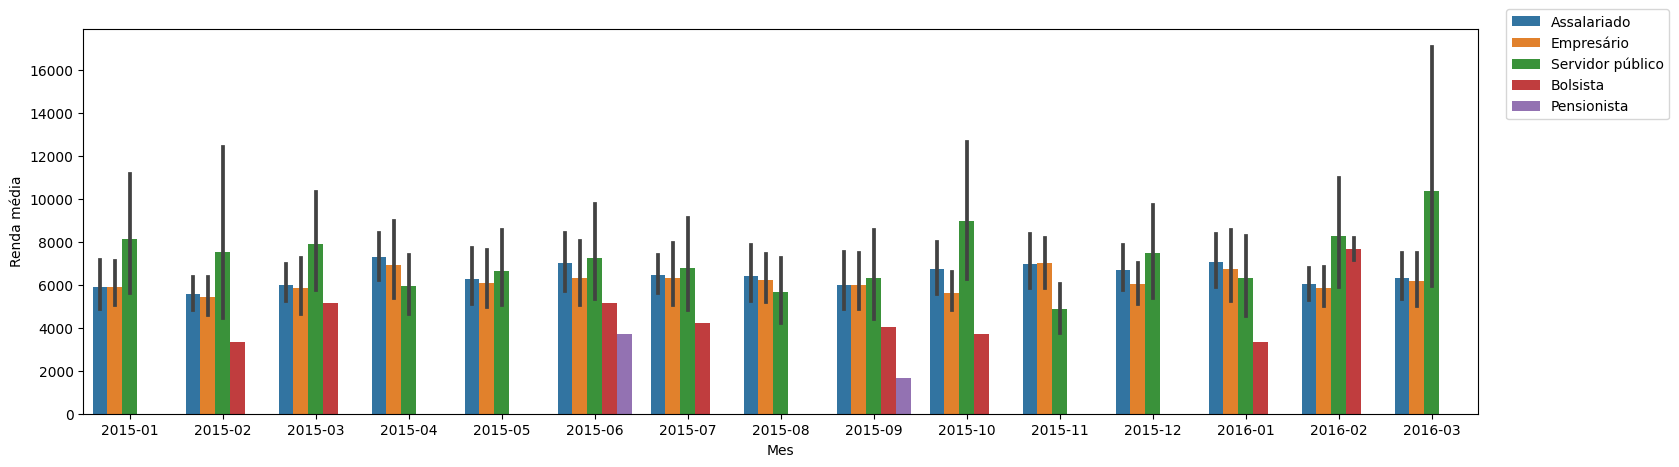

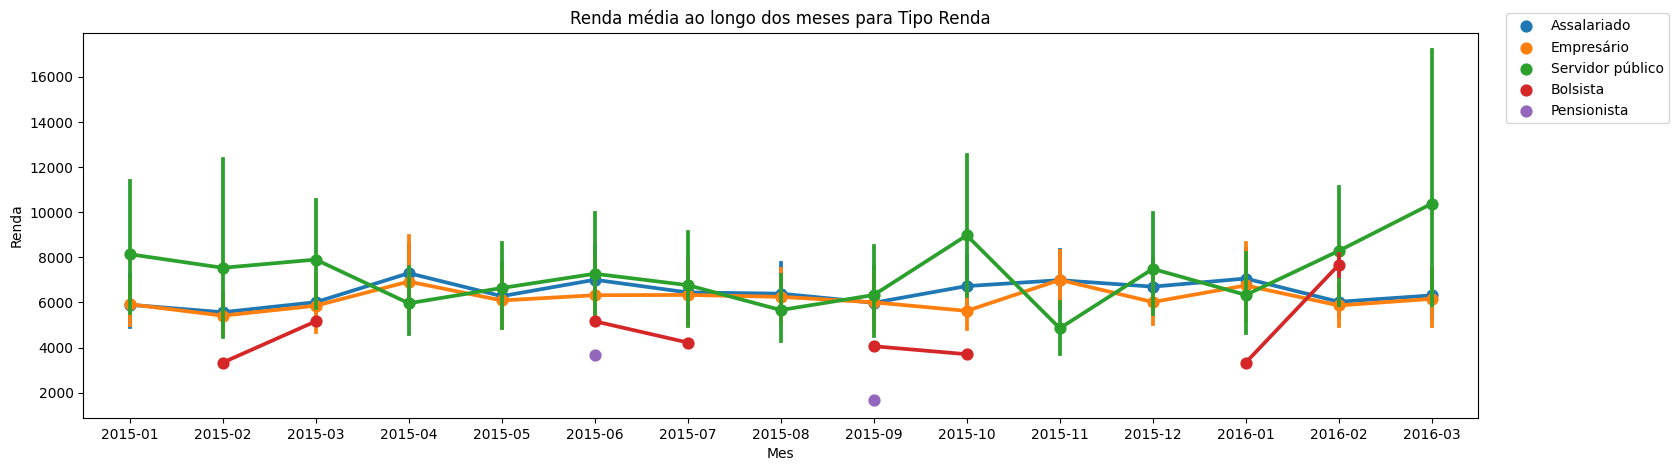

In [36]:
c += 1
grafico_barras_stack(df=df, coluna=coluna[c])
grafico_barras(df=df, coluna=coluna[c])
grafico_pontos(df=df, coluna=coluna[c])

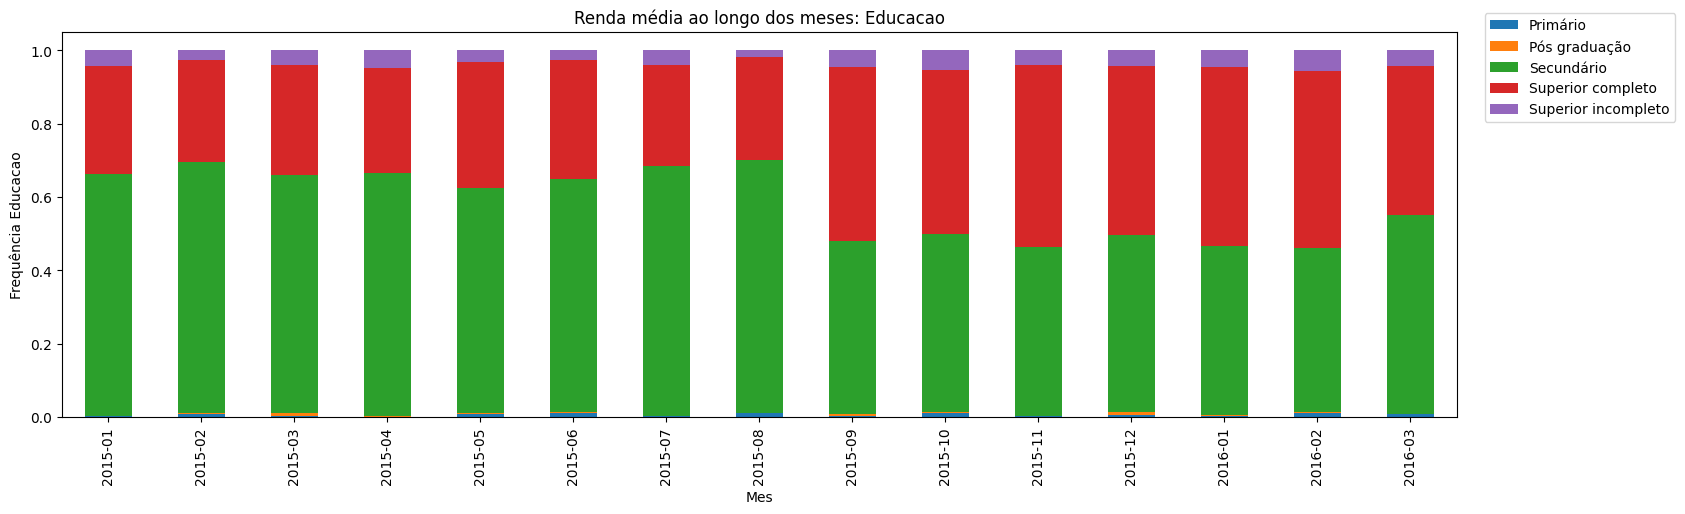

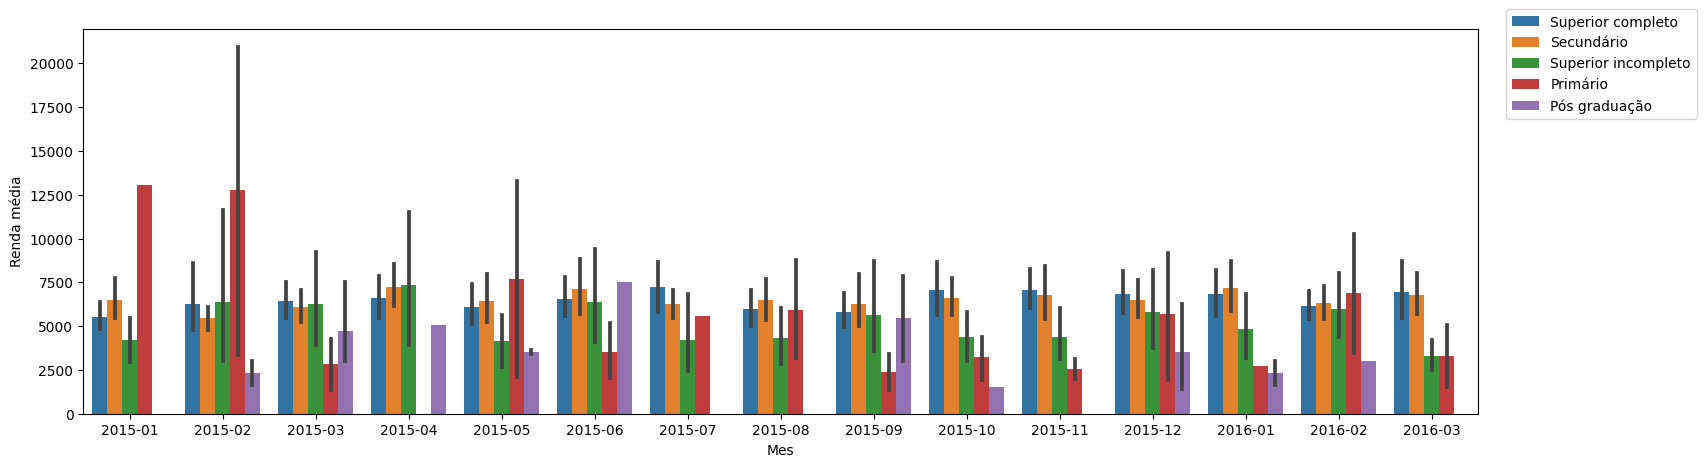

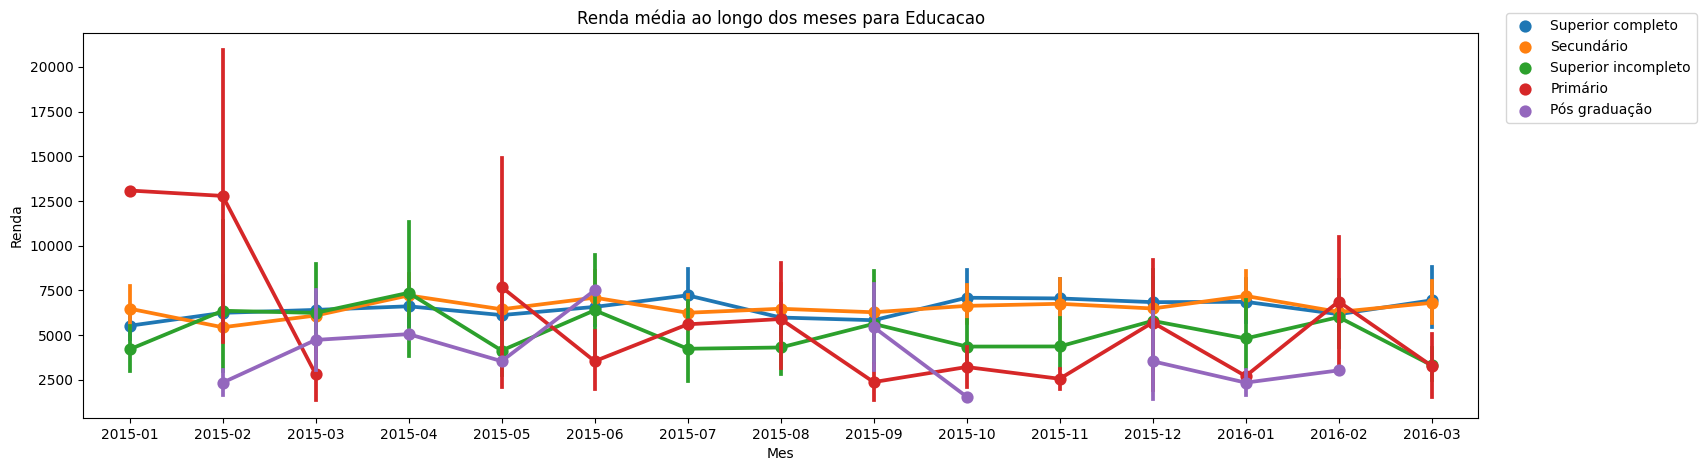

In [37]:
c += 1
grafico_barras_stack(df=df, coluna=coluna[c])
grafico_barras(df=df, coluna=coluna[c])
grafico_pontos(df=df, coluna=coluna[c])

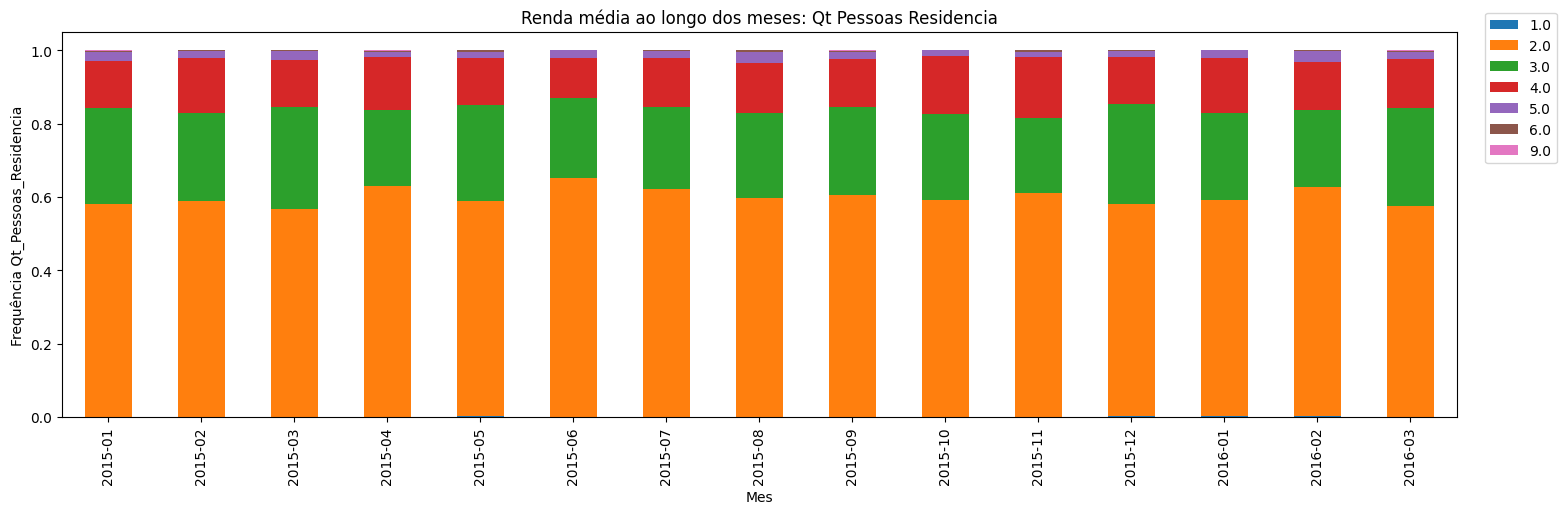

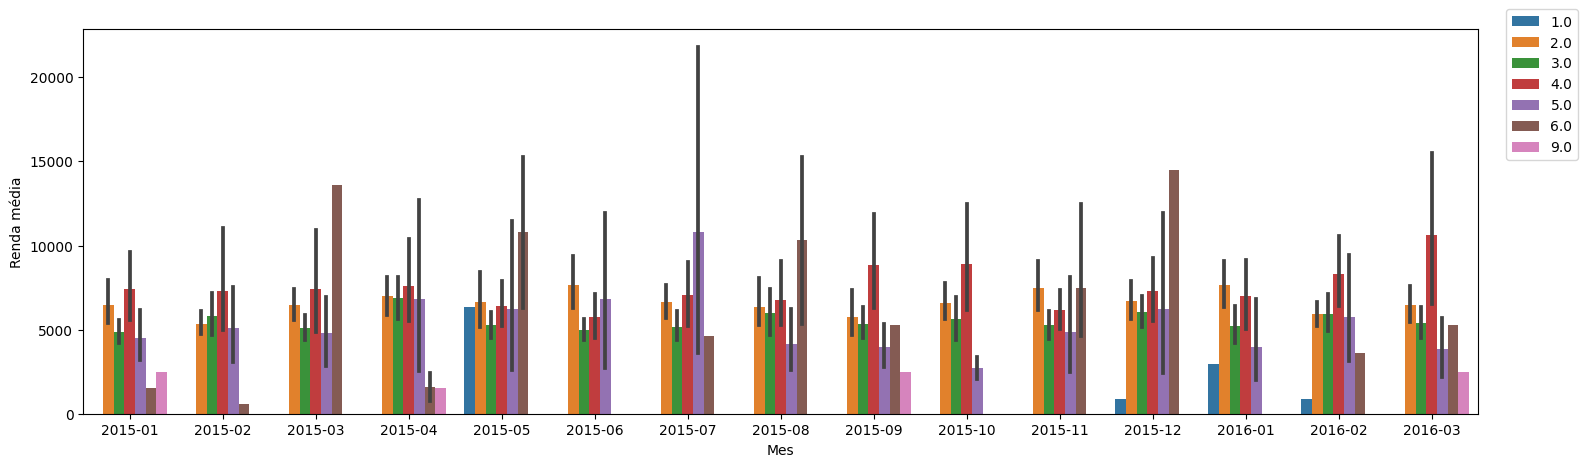

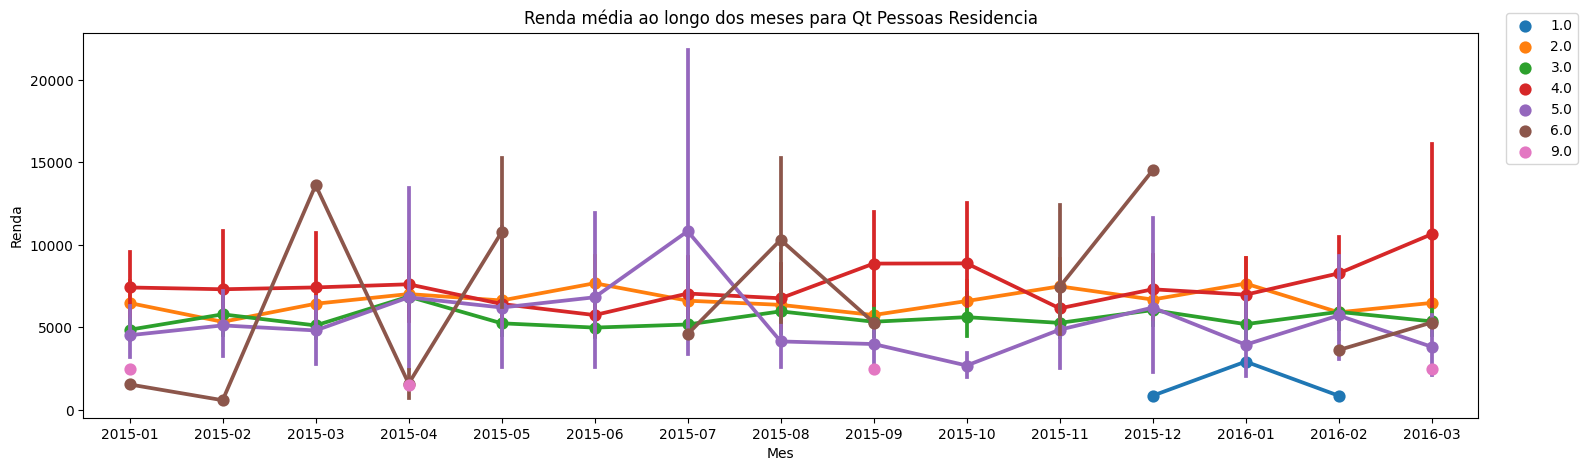

In [38]:
c += 1
grafico_barras_stack(df=df, coluna=coluna[c])
grafico_barras(df=df, coluna=coluna[c])
grafico_pontos(df=df, coluna=coluna[c])

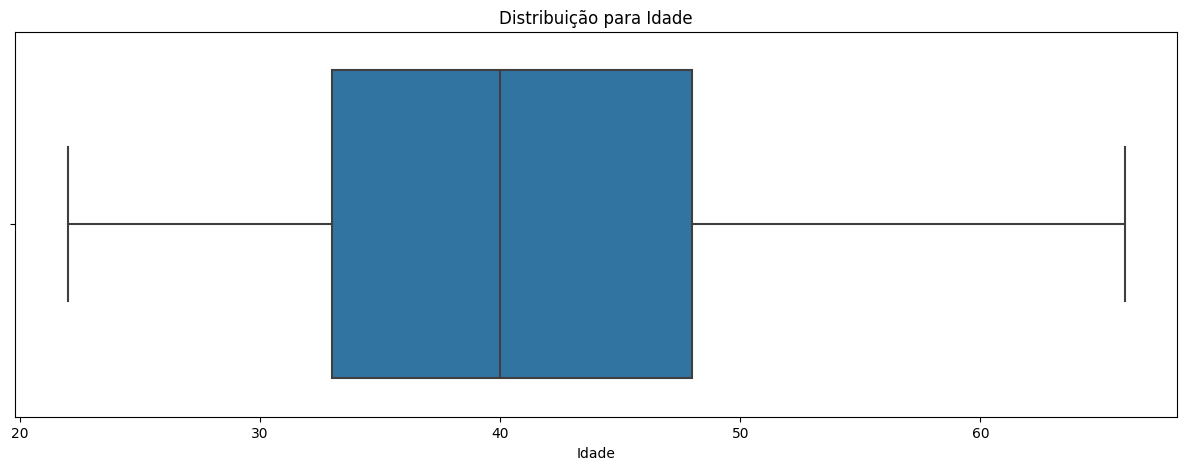

In [39]:
# Verificando variáveis categóricas
coluna = df_quantitativas.columns
c = 0
grafico_boxplot(df=df, coluna=coluna[c])

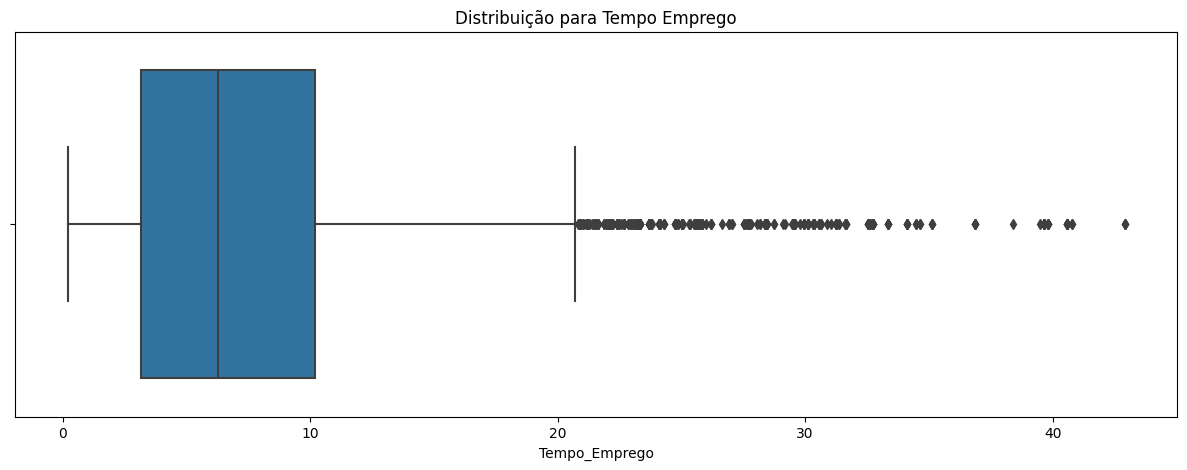

In [40]:
c += 1
grafico_boxplot(df=df, coluna=coluna[c])

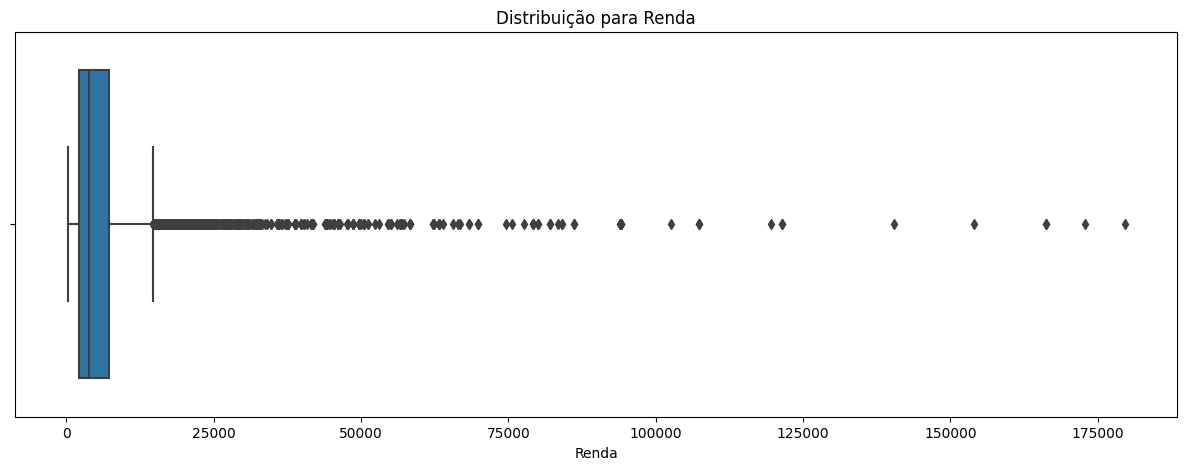

In [41]:
c += 1
grafico_boxplot(df=df, coluna=coluna[c])

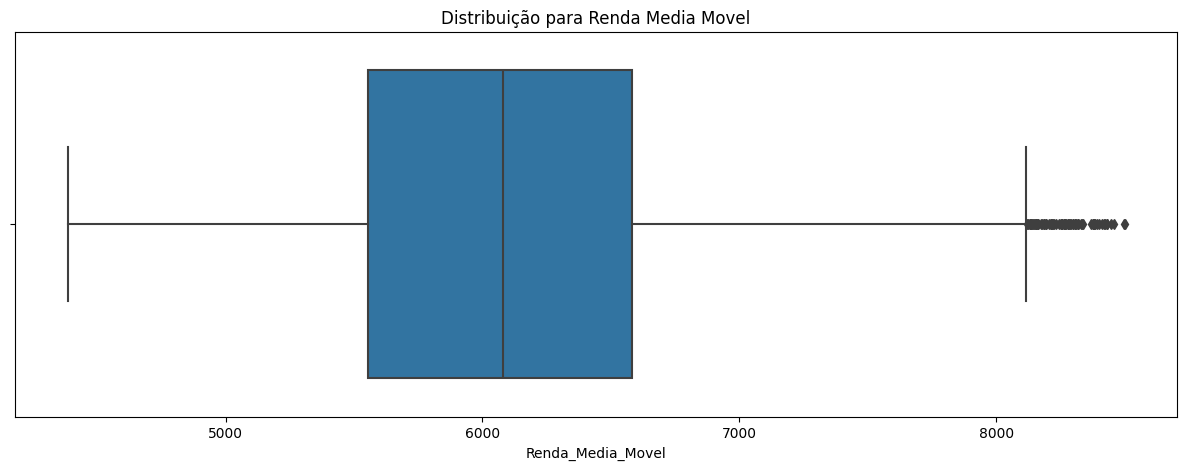

In [42]:
c += 1
grafico_boxplot(df=df, coluna=coluna[c])

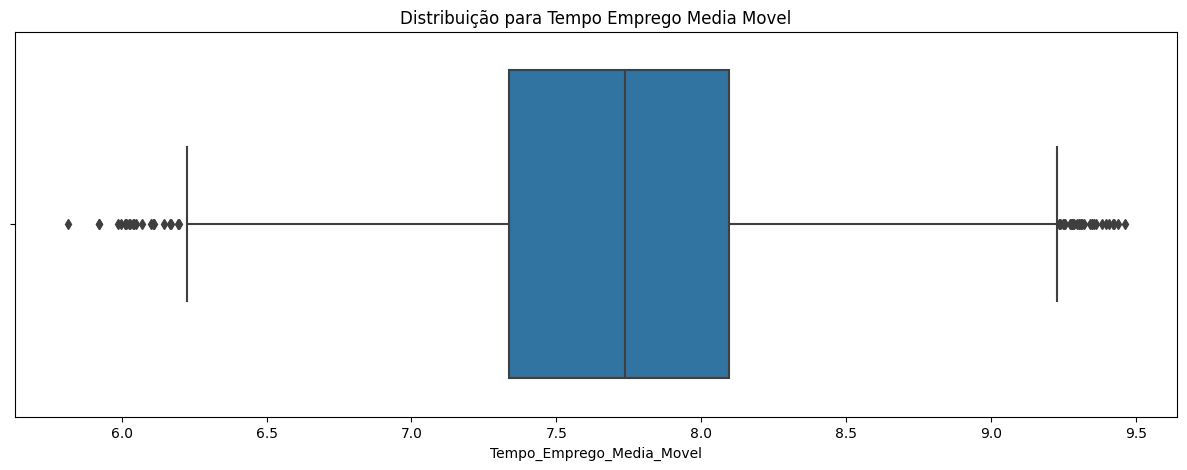

In [43]:
c += 1
grafico_boxplot(df=df, coluna=coluna[c])

#### Conclusão

Qualitativas:

- Das variáveis qualitativas a que parece ser mais estável em relação a renda ao longo do tempo é `sexo`. Essa variável pode ser usada no modelo.

- As variáveis listadas abaixo podem ser consideradas relativamente estáveis e poderiam ser usadas no modelo, com caltela. Ao longo do tempo, em relação a renda, elas apresentam poucas variações:
  <br>-- posse_de_veiculo
  <br>-- posse_de_imovel
  <br>-- estado_civil
  <br>-- tipo_residencia

- Já na variéval `educacao` e a `tipo de renda`, na categoria *pós-graduação* e *Bolsista*, aparece uma variação no intervalor, que não está presente nos demais pontos. Não usaria essas duas variáveis no modelo

Quantitativas:

- Das variáveis quantitativas independentes temos `idade`, que têm uma distribuição normal.
- Já a `tempo de emprego`, sendo essa normal com a presença de outliers, por isso essa foi transformada com média móvel. 

### Entendimento dos dados - Bivariadas




In [44]:
df_corr_quantitativas = df_quantitativas.corr()
df_corr_quantitativas

,idade,tempo_emprego,renda,renda_media_movel,tempo_emprego_media_movel
idade,1.000000,0.287726,0.128504,0.003067,0.023036
tempo_emprego,0.287726,1.000000,0.404301,0.042079,0.058580
renda,0.128504,0.404301,1.000000,0.085514,0.026755
renda_media_movel,0.003067,0.042079,0.085514,1.000000,0.347557
tempo_emprego_media_movel,0.023036,0.058580,0.026755,0.347557,1.000000


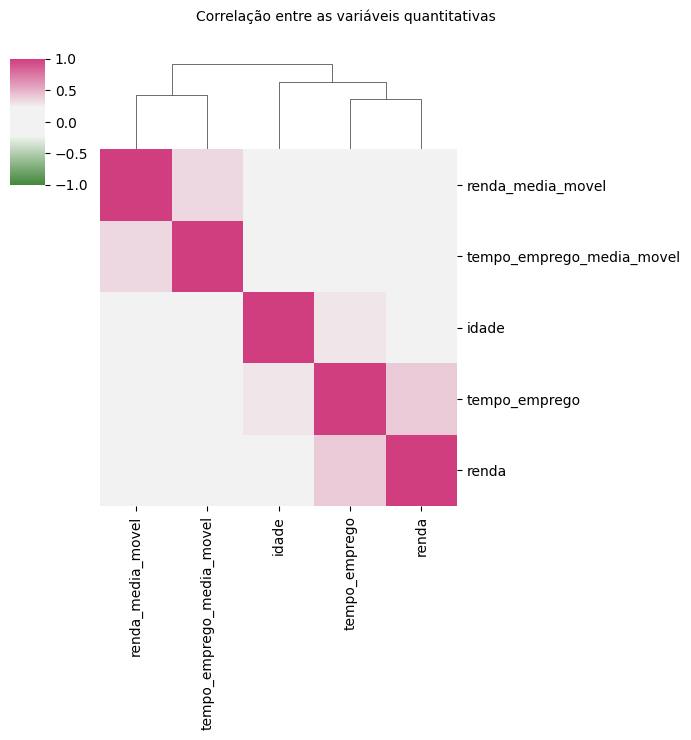

In [45]:
# Plotando as correlações
cmap = sns.diverging_palette(
    h_neg=125,
    h_pos=350,
    as_cmap=True,
    sep=60,
    center="light"
)

g = sns.clustermap(
    data=df_corr_quantitativas,
    figsize=(7,7),
    center=0,
    cmap=cmap,
    vmin=-1,
    vmax=1,
    # mask=mask
)
g.ax_row_dendrogram.set_visible(False)
g.fig.suptitle("Correlação entre as variáveis quantitativas", y=1.05, size=10)

plt.show()

In [46]:
df_corr_quantitativas.renda.nlargest(4).sort_values()

renda_media_movel    0.085514
idade                0.128504
tempo_emprego        0.404301
renda                1.000000
Name: renda, dtype: float64

In [47]:
df_corr_quantitativas.renda.nsmallest(3).sort_values()

tempo_emprego_media_movel    0.026755
renda_media_movel            0.085514
idade                        0.128504
Name: renda, dtype: float64

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


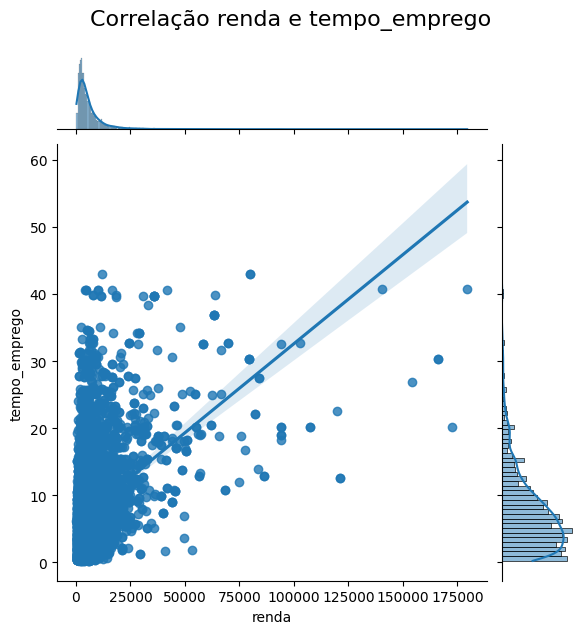

In [48]:
# Plotando a relação entre a variável dependente e a com maior correlação
prim = "renda"
segun = "tempo_emprego"
f = sns.jointplot(
    x=prim,
    y=segun,
    kind="reg",
    data=df,
)

title = f"Correlação {prim} e {segun}"
plt.suptitle(title, y=1.05, size=16)
plt.show()

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


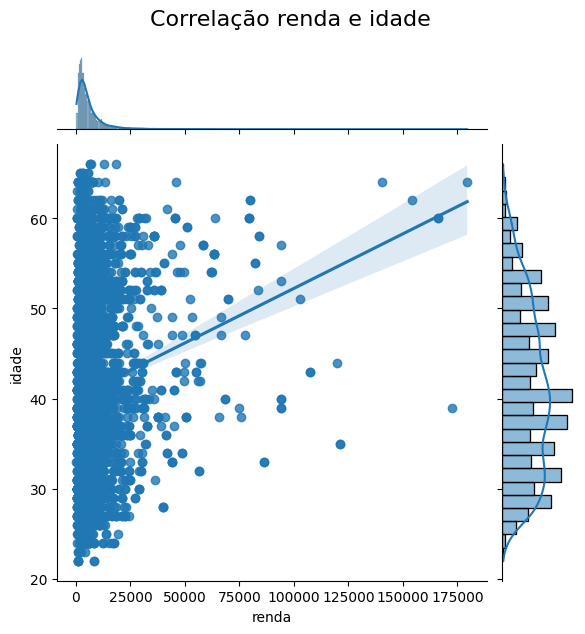

In [49]:
# Plotando a relação entre a variável dependente e a com maior correlação
prim = "renda"
segun = "idade"
f = sns.jointplot(
    x=prim,
    y=segun,
    kind="reg",
    data=df,
)

title = f"Correlação {prim} e {segun}"
plt.suptitle(title, y=1.05, size=16)
plt.show()

In [50]:
df_qualitativas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7747 entries, 1 to 14998
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   sexo                   7747 non-null   object  
 1   posse_de_veiculo       7747 non-null   bool    
 2   posse_de_imovel        7747 non-null   bool    
 3   qtd_filhos             7747 non-null   category
 4   tipo_renda             7747 non-null   object  
 5   educacao               7747 non-null   object  
 6   qt_pessoas_residencia  7747 non-null   category
dtypes: bool(2), category(2), object(3)
memory usage: 272.9+ KB


d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


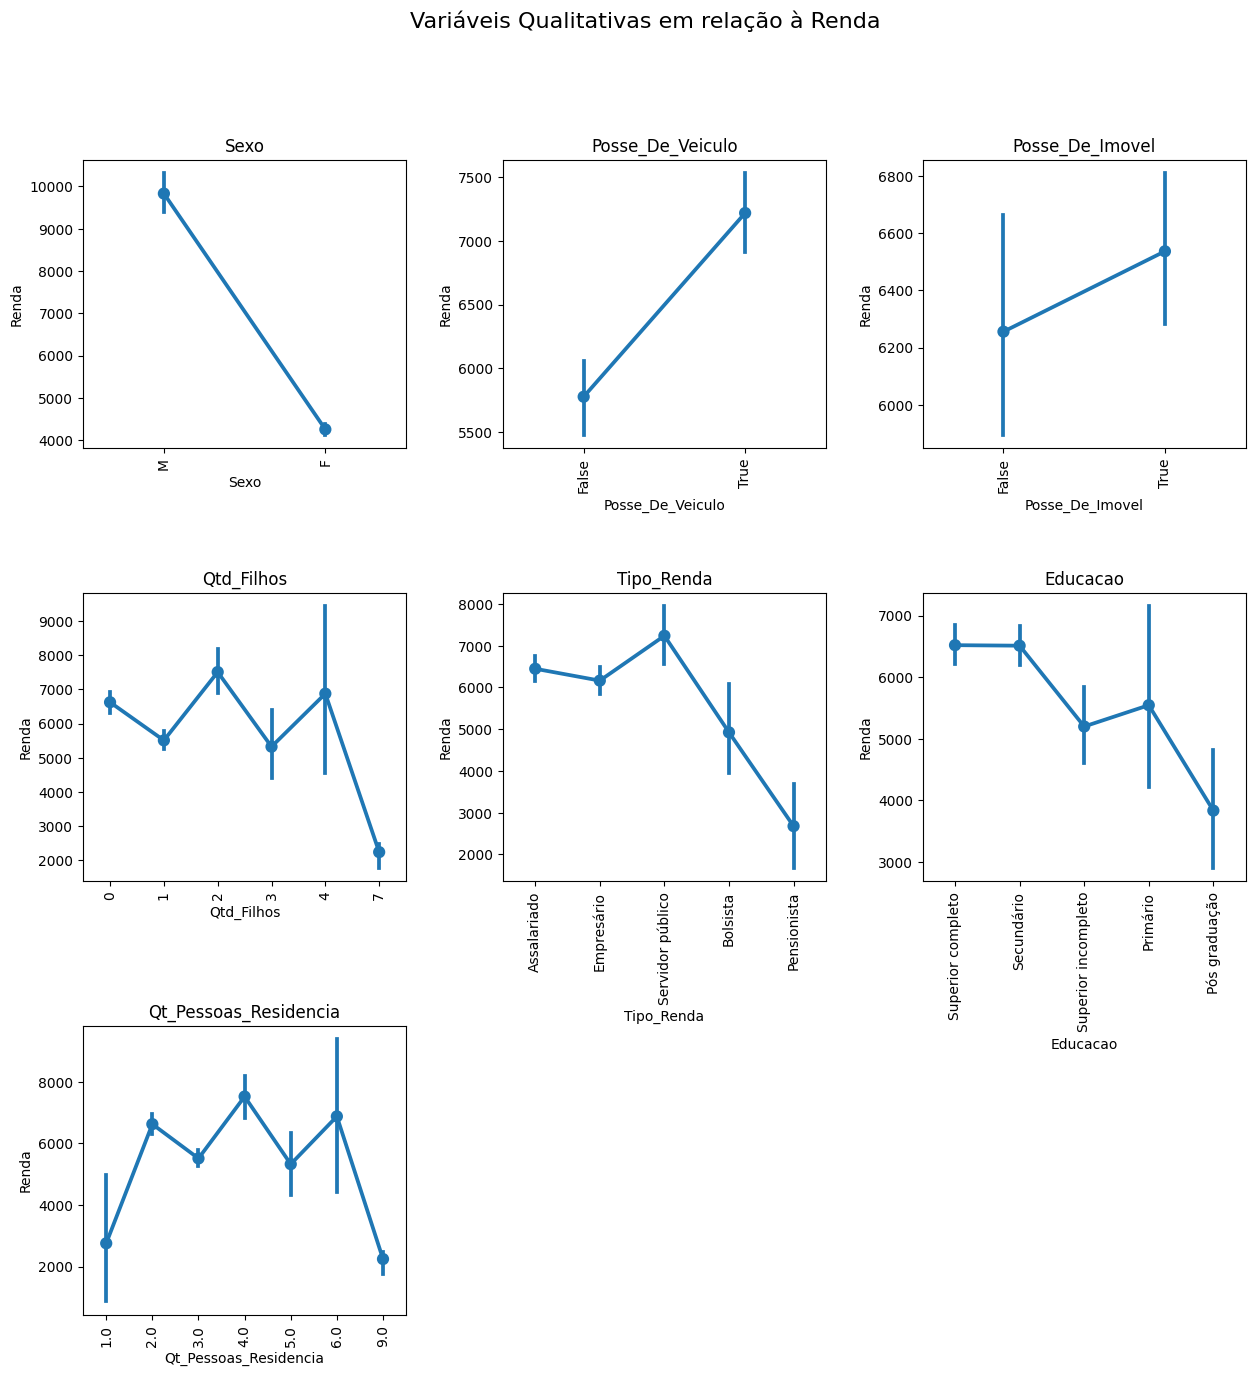

In [51]:
# Plot das variáveis qualitativas posse de imóvel e veículo.
figura, eixos = plt.subplots(3,3, figsize=(15,15))
figura.delaxes(eixos[2,1])
figura.delaxes(eixos[2,2])

plt.suptitle('Variáveis Qualitativas em relação à Renda', size=16)

c = 0
for k in [0,1,2]:
    for v in [0,1,2]:
        coluna = df_qualitativas.columns[c]
        grafico_pontos_intervalo(df=df, coluna=coluna, eixos=eixos[k,v])
        c += 1
        if k == 2 and v == 0:
            break

plt.show()

#### Conclusão
- Idade e tempo de renda são as variáveis com as melhores correlações com a renda.
- As variáveis qualitativas parecem ter relação com a renda.

---

## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


### Rodando o modelo


In [52]:
printLis(df.columns)

-------------
-=< Lista >=-
-------------
0 -> data_ref
1 -> sexo
2 -> posse_de_veiculo
3 -> posse_de_imovel
4 -> qtd_filhos
5 -> tipo_renda
6 -> educacao
7 -> idade
8 -> tempo_emprego
9 -> qt_pessoas_residencia
10 -> renda
11 -> renda_media_movel
12 -> tempo_emprego_media_movel


In [53]:
colunas = [1,2,3,4,5,6,7,8,9,10]
printLis(df.iloc[:, colunas].columns)

-------------
-=< Lista >=-
-------------
0 -> sexo
1 -> posse_de_veiculo
2 -> posse_de_imovel
3 -> qtd_filhos
4 -> tipo_renda
5 -> educacao
6 -> idade
7 -> tempo_emprego
8 -> qt_pessoas_residencia
9 -> renda


In [54]:
def divide_df(df: pd.DataFrame) -> tuple:
    # Separando a DataFrame em variáveis independentes (x) e dependente (y)
    x = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    # Obtendo os conjuntos de dados de teste e treino
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)
    print(
        x_train.shape,
        x_test.shape,
        y_train.shape,
        y_test.shape
    )
    # Construindo novamente a DataFrame, agora de treino
    df_train = pd.DataFrame(columns=df.columns[:-1], data=x_train)
    df_train[df.columns[-1]] = y_train
    # Construindo novamente a DataFrame, agora de teste
    df_test = pd.DataFrame(columns=df.columns[:-1], data=x_test)
    df_test[df.columns[-1]] = y_test

    return (df_test, df_train)

In [55]:
df_test, df_train = divide_df(df=df.iloc[:, colunas])
printLis(df_train.columns)

(5810, 9) (1937, 9) (5810,) (1937,)
-------------
-=< Lista >=-
-------------
0 -> sexo
1 -> posse_de_veiculo
2 -> posse_de_imovel
3 -> qtd_filhos
4 -> tipo_renda
5 -> educacao
6 -> idade
7 -> tempo_emprego
8 -> qt_pessoas_residencia
9 -> renda


In [56]:
printLis(df_test.columns)

-------------
-=< Lista >=-
-------------
0 -> sexo
1 -> posse_de_veiculo
2 -> posse_de_imovel
3 -> qtd_filhos
4 -> tipo_renda
5 -> educacao
6 -> idade
7 -> tempo_emprego
8 -> qt_pessoas_residencia
9 -> renda


In [57]:
def mais_frequente(base: pd.DataFrame, coluna: str) -> None:
  '''
  Função que analisa as categorias na variável recebida, imprimindo a mais
  frequênte
  :param coluna (str): Nome da coluna à ser analisada.
  '''
  print(coluna)
  print(base[coluna].value_counts(normalize=True).index[0])

In [58]:
'''
Para obtendo o modelo de regressão com as categorias mais frequêntes
 nas caselas, verificou-se qual valor é mais frequênte em cada variável
'''

for c in range(len(df_qualitativas.columns)):
  mais_frequente(base=df_qualitativas, coluna=df_qualitativas.columns[c])
  print("-"*10)

sexo
F
----------
posse_de_veiculo
False
----------
posse_de_imovel
True
----------
qtd_filhos
0
----------
tipo_renda
Assalariado
----------
educacao
Secundário
----------
qt_pessoas_residencia
2.0
----------


In [59]:
printLis(df_quantitativas.columns)

-------------
-=< Lista >=-
-------------
0 -> idade
1 -> tempo_emprego
2 -> renda
3 -> renda_media_movel
4 -> tempo_emprego_media_movel


In [60]:
dump(os.listdir(), "./output/test")

['./output/test']

In [62]:
# Obtendo o modelo de regressão com as categorias mais frequêntes nas caselas
formula = '''
                np.log(renda) ~
                idade +
                tempo_emprego +
                C(sexo, Treatment('F')) +
                C(posse_de_veiculo, Treatment(False)) +
                C(posse_de_imovel, Treatment(True)) +
                C(qtd_filhos, Treatment(0)) +
                C(tipo_renda, Treatment('Assalariado')) +
                C(educacao, Treatment('Secundário')) +
                C(qt_pessoas_residencia, Treatment(2.0))
          '''

y, x = patsy.dmatrices(formula, df_train, return_type="dataframe")

# Instanciando a regressão com todas as variáveis. Essa será usada como benchmarks
regressao_benchmarks = sm.OLS(y, x).fit()
dump(regressao_benchmarks, "./output/modelos/regressao_benchmarks")
print(regressao_benchmarks.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     174.4
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:24:39   Log-Likelihood:                -6393.8
No. Observations:                5810   AIC:                         1.283e+04
Df Residuals:                    5789   BIC:                         1.297e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

- O modelo contendo todas as variáveis obteve um R² de 0.373, sendo esse o **benchmark** 

In [63]:
colunas = [1,2,3,4,5,6,7,8,9,11]
printLis(df.iloc[:, colunas].columns)

-------------
-=< Lista >=-
-------------
0 -> sexo
1 -> posse_de_veiculo
2 -> posse_de_imovel
3 -> qtd_filhos
4 -> tipo_renda
5 -> educacao
6 -> idade
7 -> tempo_emprego
8 -> qt_pessoas_residencia
9 -> renda_media_movel


In [64]:
# Obtendo o modelo de regressão com as categorias mais frequêntes nas caselas
formula = '''
                renda_media_movel ~
                idade +
                tempo_emprego +
                C(sexo, Treatment('F')) +
                C(posse_de_veiculo, Treatment(False)) +
                C(posse_de_imovel, Treatment(True)) +
                C(qtd_filhos, Treatment(0)) +
                C(tipo_renda, Treatment('Assalariado')) +
                C(educacao, Treatment('Secundário')) +
                C(qt_pessoas_residencia, Treatment(2.0))
          '''
# Seperando teste e treino
df_test, df_train = divide_df(df=df.iloc[:, colunas])

# Instanciando as variáveis dependentes e independentes
y, x = patsy.dmatrices(formula, df_train, return_type="dataframe")

# Instanciando a regressão com todas as variáveis. Essa será usada como benchmarks
regressao_benchmarks = sm.OLS(y, x).fit()
dump(regressao_benchmarks, "./output/modelos/regressao_benchmarks")
print(regressao_benchmarks.summary())

(5810, 9) (1937, 9) (5810,) (1937,)
                            OLS Regression Results                            
Dep. Variable:      renda_media_movel   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.694
Date:                Thu, 18 Apr 2024   Prob (F-statistic):             0.0273
Time:                        16:29:35   Log-Likelihood:                -46506.
No. Observations:                5810   AIC:                         9.305e+04
Df Residuals:                    5789   BIC:                         9.319e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

- O modelo contendo a média móvel da renda teve R² de 0.017.

In [65]:
colunas = [1,2,3,4,5,6,7,12,9,10]
printLis(df.iloc[:, colunas].columns)

-------------
-=< Lista >=-
-------------
0 -> sexo
1 -> posse_de_veiculo
2 -> posse_de_imovel
3 -> qtd_filhos
4 -> tipo_renda
5 -> educacao
6 -> idade
7 -> tempo_emprego_media_movel
8 -> qt_pessoas_residencia
9 -> renda


In [66]:
# Obtendo o modelo de regressão com as categorias mais frequêntes nas caselas
formula = '''
                np.log(renda) ~
                idade +
                tempo_emprego_media_movel +
                C(sexo, Treatment('F')) +
                C(posse_de_veiculo, Treatment(False)) +
                C(posse_de_imovel, Treatment(True)) +
                C(qtd_filhos, Treatment(0)) +
                C(tipo_renda, Treatment('Assalariado')) +
                C(educacao, Treatment('Secundário')) +
                C(qt_pessoas_residencia, Treatment(2.0))
          '''
# Seperando teste e treino
df_test, df_train = divide_df(df=df.iloc[:, colunas])

# Instanciando as variáveis dependentes e independentes
y, x = patsy.dmatrices(formula, df_train, return_type="dataframe")

# Instanciando a regressão com todas as variáveis. Essa será usada como benchmarks
regressao_benchmarks = sm.OLS(y, x).fit()
dump(regressao_benchmarks, "./output/modelos/regressao_benchmarks")
print(regressao_benchmarks.summary())

(5810, 9) (1937, 9) (5810,) (1937,)
                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     67.44
Date:                Thu, 18 Apr 2024   Prob (F-statistic):          6.22e-245
Time:                        16:29:47   Log-Likelihood:                -7155.5
No. Observations:                5810   AIC:                         1.435e+04
Df Residuals:                    5789   BIC:                         1.449e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

- O modelo contendo a média móvel do tempo emprego teve R² de 0.205.

In [67]:
colunas = [1,2,3,4,5,6,7,12,9,11]
printLis(df.iloc[:, colunas].columns)

-------------
-=< Lista >=-
-------------
0 -> sexo
1 -> posse_de_veiculo
2 -> posse_de_imovel
3 -> qtd_filhos
4 -> tipo_renda
5 -> educacao
6 -> idade
7 -> tempo_emprego_media_movel
8 -> qt_pessoas_residencia
9 -> renda_media_movel


In [68]:
# Obtendo o modelo de regressão com as categorias mais frequêntes nas caselas
formula = '''
                renda_media_movel ~
                idade +
                tempo_emprego_media_movel +
                C(sexo, Treatment('F')) +
                C(posse_de_veiculo, Treatment(False)) +
                C(posse_de_imovel, Treatment(True)) +
                C(qtd_filhos, Treatment(0)) +
                C(tipo_renda, Treatment('Assalariado')) +
                C(educacao, Treatment('Secundário')) +
                C(qt_pessoas_residencia, Treatment(2.0))
          '''
# Seperando teste e treino
df_test, df_train = divide_df(df=df.iloc[:, colunas])

# Instanciando as variáveis dependentes e independentes
y, x = patsy.dmatrices(formula, df_train, return_type="dataframe")

# Instanciando a regressão com todas as variáveis. Essa será usada como benchmarks
regressao_benchmarks = sm.OLS(y, x).fit()
dump(regressao_benchmarks, "./output/modelos/regressao_benchmarks")
print(regressao_benchmarks.summary())

(5810, 9) (1937, 9) (5810,) (1937,)
                            OLS Regression Results                            
Dep. Variable:      renda_media_movel   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     41.49
Date:                Thu, 18 Apr 2024   Prob (F-statistic):          1.23e-151
Time:                        16:29:56   Log-Likelihood:                -46134.
No. Observations:                5810   AIC:                         9.231e+04
Df Residuals:                    5789   BIC:                         9.245e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

- O modelo contendo a média móvel do tempo emprego e renda teve R² de 0.130.

In [69]:
colunas = [1,2,3,4,5,6,7,8,9,10]
printLis(df.iloc[:, colunas].columns)

-------------
-=< Lista >=-
-------------
0 -> sexo
1 -> posse_de_veiculo
2 -> posse_de_imovel
3 -> qtd_filhos
4 -> tipo_renda
5 -> educacao
6 -> idade
7 -> tempo_emprego
8 -> qt_pessoas_residencia
9 -> renda


In [70]:
# Obtendo o modelo de regressão com as categorias mais frequêntes nas caselas
formula = '''
                np.log(renda) ~
                idade +
                tempo_emprego +
                C(sexo, Treatment('F')) +
                C(posse_de_veiculo, Treatment(False)) +
                C(posse_de_imovel, Treatment(True)) +
                C(qtd_filhos, Treatment(0)) +
                C(tipo_renda, Treatment('Assalariado')) +
                C(educacao, Treatment('Secundário')) +
                C(qt_pessoas_residencia, Treatment(2.0))
          '''
# Seperando teste e treino
df_test, df_train = divide_df(df=df.iloc[:, colunas])

# Instanciando as variáveis dependentes e independentes
y, x = patsy.dmatrices(formula, df_train, return_type="dataframe")

# Instanciando a regressão com todas as variáveis. Essa será usada como benchmarks
regressao_benchmarks = sm.OLS(y, x).fit()
dump(regressao_benchmarks, "./output/modelos/regressao_benchmarks")
print(regressao_benchmarks.summary())

(5810, 9) (1937, 9) (5810,) (1937,)
                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     174.4
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:30:06   Log-Likelihood:                -6393.8
No. Observations:                5810   AIC:                         1.283e+04
Df Residuals:                    5789   BIC:                         1.297e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [71]:
# Determinação do modelo com regularização Ridge, com L1_wt = 1e-100
L1_wt = 1/(10**100)

alphas = [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0]

modelo = smf.ols(formula, data=df_train)

# Determinação do modelo com regularização Ridge, os diferentes alpha
for alpha in alphas:
  regressao_ridge = modelo.fit_regularized(
                                      method = 'elastic_net',
                                      refit=True,
                                      L1_wt=L1_wt,
                                      alpha=alpha
  )
  print("_"*100)
  print(f"Alpha         : {alpha}")
  print(f"R²            : {regressao_ridge.rsquared:.5f}")
  print(f"R² ajust      : {regressao_ridge.rsquared_adj:.5f}")
  print(f"AIC           : {regressao_ridge.aic:.5f}")
  print(f"Média p-value : {np.mean(regressao_ridge.pvalues):.5f}")

____________________________________________________________________________________________________
Alpha         : 1.0
R²            : 0.37605
R² ajust      : 0.37346
AIC           : 12839.53816
Média p-value : 0.20736
____________________________________________________________________________________________________
Alpha         : 0.5
R²            : 0.37605
R² ajust      : 0.37346
AIC           : 12839.53816
Média p-value : 0.20736
____________________________________________________________________________________________________
Alpha         : 0.1
R²            : 0.37605
R² ajust      : 0.37346
AIC           : 12839.53816
Média p-value : 0.20736
____________________________________________________________________________________________________
Alpha         : 0.05
R²            : 0.37605
R² ajust      : 0.37346
AIC           : 12839.53816
Média p-value : 0.20736
____________________________________________________________________________________________________
Alpha         

In [72]:
dump(regressao_ridge, "./output/modelos/regressao_ridge")
print(regressao_ridge.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     145.3
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:30:25   Log-Likelihood:                -6393.8
No. Observations:                5810   AIC:                         1.284e+04
Df Residuals:                    5786   BIC:                         1.300e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


- O modelo obtido com a regularização Ridge com alpha 0.0 teve R² de 0.373.

In [73]:
# Determinação do modelo com regularização Ridge, com L1_wt = 1e-100
L1_wt = 1

modelo = smf.ols(formula, data=df_train)

# Determinação do modelo com regularização Ridge, os diferentes alpha
for alpha in alphas:
  regressao_lasso = modelo.fit_regularized(
                                      method = 'elastic_net',
                                      refit=True,
                                      L1_wt=L1_wt,
                                      alpha=alpha
  )
  print("_"*100)
  print(f"Alpha         : {alpha}")
  print(f"R²            : {regressao_lasso.rsquared:.5f}")
  print(f"R² ajust      : {regressao_lasso.rsquared_adj:.5f}")
  print(f"AIC           : {regressao_lasso.aic:.5f}")
  print(f"Média p-value : {np.mean(regressao_lasso.pvalues):.5f}")

____________________________________________________________________________________________________
Alpha         : 1.0
R²            : -3.29211
R² ajust      : -3.29285
AIC           : 23997.86436
Média p-value : nan
____________________________________________________________________________________________________
Alpha         : 0.5
R²            : -3.29211
R² ajust      : -3.29285
AIC           : 23997.86436
Média p-value : nan
____________________________________________________________________________________________________
Alpha         : 0.1
R²            : 0.36022
R² ajust      : 0.35989
AIC           : 12943.09702
Média p-value : nan
____________________________________________________________________________________________________
Alpha         : 0.05
R²            : 0.36022
R² ajust      : 0.35989
AIC           : 12943.09702
Média p-value : nan
____________________________________________________________________________________________________
Alpha         : 0.01
R²   

____________________________________________________________________________________________________
Alpha         : 0.001
R²            : 0.37312
R² ajust      : 0.37204
AIC           : 12838.70462
Média p-value : nan
____________________________________________________________________________________________________
Alpha         : 0.0
R²            : 0.37605
R² ajust      : 0.37357
AIC           : 12837.53816
Média p-value : nan


In [74]:
dump(regressao_lasso, "./output/modelos/regressao_lasso")
print(regressao_lasso.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     145.3
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:30:55   Log-Likelihood:                -6393.8
No. Observations:                5810   AIC:                         1.284e+04
Df Residuals:                    5786   BIC:                         1.300e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


- O modelo obtido com a regularização LASSO com apha 0.0 teve R² de 0.373.

In [75]:
'''
Verificando como ficaria um modelo onde o valor de p-value das variáveis
para beta = 0 é menor que o limite de 0,01. Isso seria o equivalente a primeira
rodada do forward do stepwise.
'''
limite_in = 0.01
limite_out = 0.05
colunas_selecionadas = list(regressao_benchmarks.pvalues[regressao_benchmarks.pvalues <= limite_in].index)
regressao_forward = sm.OLS(y, x.loc[:,colunas_selecionadas]).fit()
dump(regressao_forward, "./output/modelos/regressao_forward")
print(regressao_forward.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     431.0
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:31:26   Log-Likelihood:                -6408.8
No. Observations:                5810   AIC:                         1.284e+04
Df Residuals:                    5801   BIC:                         1.290e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

- O modelo obtido com variáveis significativas teve um R² de 0.365.

In [76]:
def regressao_stepwise_generator(limite_in: str = 0.01,limite_out: str = 0.05):
  '''
    Função para instanciamento de regressão usando a técnica de seleção de 
    modelos por stepwise.
    :param limite_in (float) = 0.01: P-value limite para a aceitação da variável
    :param limite_out (float) = 0.05: P-value limite para a regeição da variável
    :return gen_regressao_stepwise (RegressionResultsWrapper): Modelo treinado.
  '''
  colunas_in = []

  # Inicio forward com uma variável
  for column in x.columns:

    # Insere a primeira variável
    colunas_in.append(column)

    # Instancia a Regressão
    gen_regressao_in = sm.OLS(y, x.loc[:,colunas_in]).fit()

    # Varefica quais as variáveis tiveram p-value < que o limite, removendo os superiores
    colunas_in = list(gen_regressao_in.pvalues[gen_regressao_in.pvalues < limite_in].index)


  # Inicio backward, com todas as variáveis.
  colunas_out = colunas_in
  for column in colunas_in:
    try:
      # Instancia a Regressão
      gen_regressao_stepwise = sm.OLS(y, x.loc[:,colunas_out]).fit()
      
      # Verifica quais as variáveis tiveram p-value > que o limite, removendo os inferiores
      colunas_out = list(gen_regressao_stepwise.pvalues[gen_regressao_stepwise.pvalues > limite_out].index)

      # Retira a primeira variável
      colunas_out.remove(column)
    except:
      pass
  
  # Retorna o modelo treinado
  return gen_regressao_stepwise

In [77]:
# Instanciando a regressão com a técnica stepwise
regressao_stepwise = regressao_stepwise_generator()
dump(regressao_stepwise, "./output/modelos/regressao_stepwise")
print(regressao_stepwise.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     668.3
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:31:46   Log-Likelihood:                -6443.1
No. Observations:                5810   AIC:                         1.290e+04
Df Residuals:                    5804   BIC:                         1.294e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

- O modelo obtido com a regularização stepwise teve um R² de 0.359.

## Etapa 5 Crisp-DM: Avaliação dos resultados


In [78]:
# Organizando as métricas dos modelos obtidos
modelos = "Benchmarks Ridge LASSO Forward Stepwise".split(" ")
df_metricas = pd.DataFrame(
    data={
        "Modelo": modelos,
        "R²": [
            regressao_benchmarks.rsquared,
            regressao_ridge.rsquared,
            regressao_lasso.rsquared,
            regressao_forward.rsquared,
            regressao_stepwise.rsquared
        ],
        "R² adj": [
            regressao_benchmarks.rsquared_adj,
            regressao_ridge.rsquared_adj,
            regressao_lasso.rsquared_adj,
            regressao_forward.rsquared_adj,
            regressao_stepwise.rsquared_adj
        ],
        "AIC": [
            regressao_benchmarks.aic,
            regressao_ridge.aic,
            regressao_lasso.aic,
            regressao_forward.aic,
            regressao_stepwise.aic
        ],
        "N vari": [
            len(regressao_benchmarks.pvalues),
            len(regressao_ridge.pvalues),
            len(regressao_lasso.pvalues),
            len(regressao_forward.pvalues),
            len(regressao_stepwise.pvalues)
        ],
        "Média p-value": [
            np.mean(regressao_benchmarks.pvalues),
            np.mean(regressao_ridge.pvalues),
            np.mean(regressao_lasso.pvalues),
            np.mean(regressao_forward.pvalues),
            np.mean(regressao_stepwise.pvalues)
        ],
    }
)
df_metricas

,Modelo,R²,R² adj,AIC,N vari,Média p-value
0,Benchmarks,0.376045,0.373890,12829.538158,25,0.207294
1,Ridge,0.376045,0.373565,12837.538158,25,NaN
2,LASSO,0.376045,0.373565,12837.538158,25,NaN
3,Forward,0.372798,0.371933,12835.696635,9,0.001415
4,Stepwise,0.365363,0.364817,12898.161510,6,0.001129


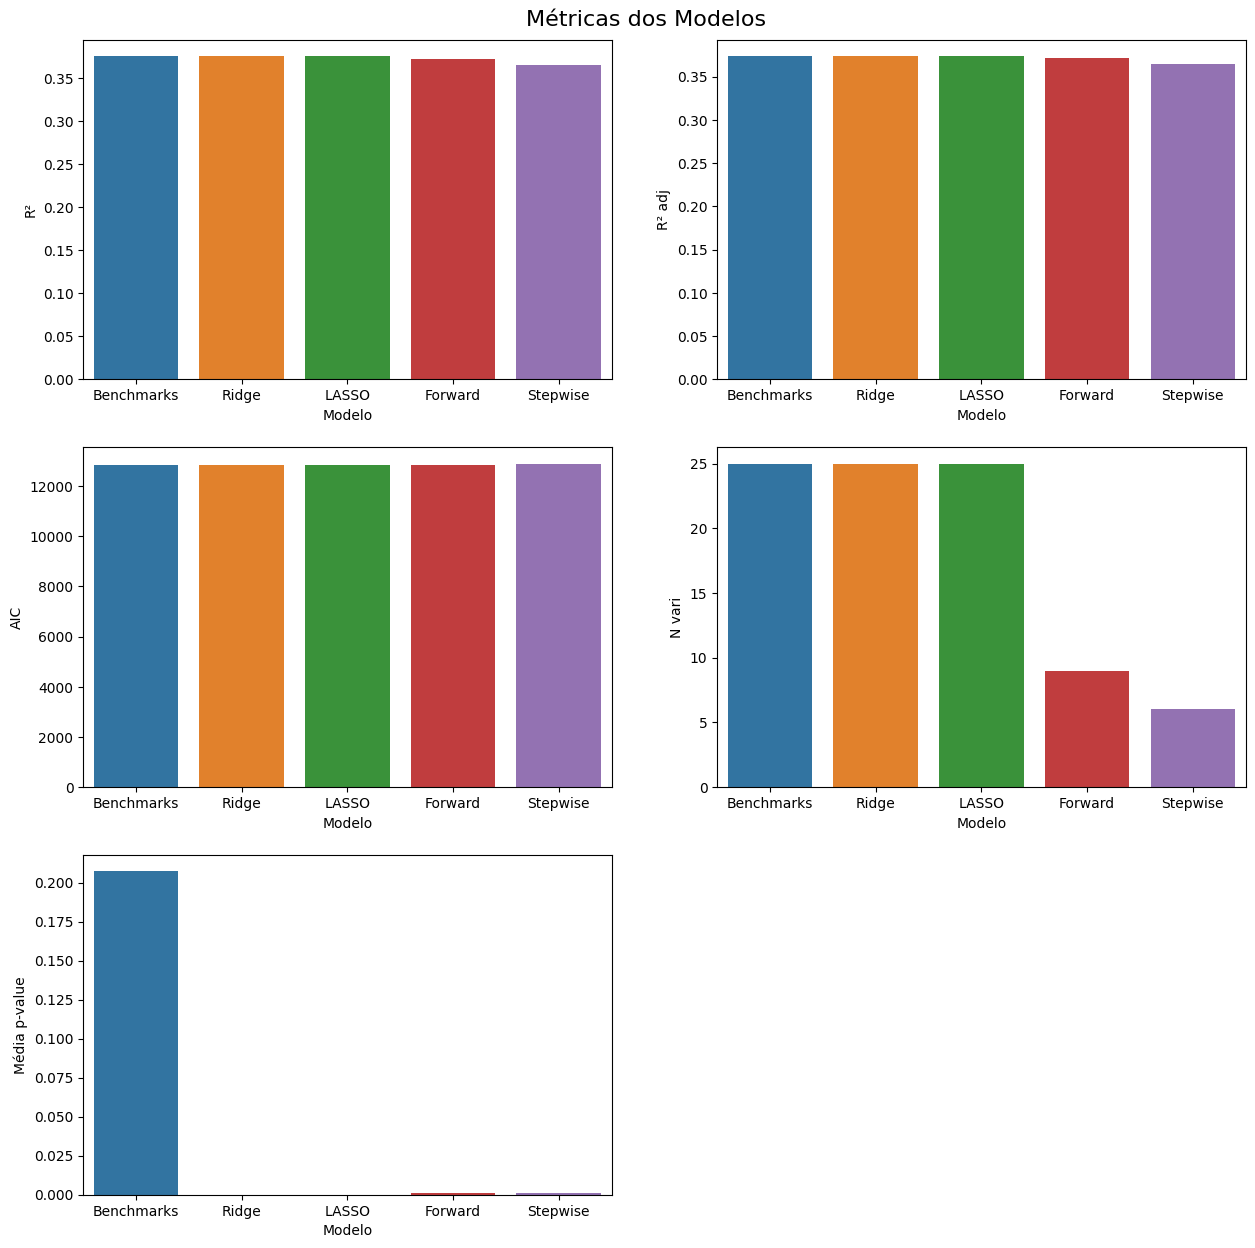

In [79]:
# Plotando as métricas dos modelos treinados.
fig, ax = plt.subplots(3,2, figsize=(15,15))
fig.delaxes(ax[2,1])

plt.suptitle("Métricas dos Modelos", y=.9, size=16)
sns.barplot(
    x="Modelo",
    y="R²",
    data=df_metricas,
    ax=ax[0,0]
)
sns.barplot(
    x="Modelo",
    y="R² adj",
    data=df_metricas,
    ax=ax[0,1]
)
sns.barplot(
    x="Modelo",
    y="AIC",
    data=df_metricas,
    ax=ax[1,0]
)
sns.barplot(
    x="Modelo",
    y="N vari",
    data=df_metricas,
    ax=ax[1,1]
)
sns.barplot(
    x="Modelo",
    y="Média p-value",
    data=df_metricas,
    ax=ax[2,0]
)
plt.show()

### Conclusão
- Foram obtidas 5 regressões usando diferentes técnicas.
<br>- Benchmarks: com todas as variáveis;
<br>- Ridge: Treinando o modelo com a técnica Ridge;
<br>- LASSO: Treinando o modelo com a técnica LASSO;
<br>- Forward: Modelo obtido com a primeira etapa do forward do stepwise;
<br>- Stepwise: Modelo obtido com o stepwise;

- Deses, o melhor modelo foi o Forward, com as métricas mais equilibradas. Foi considerado como melhor o modelo com maiores R², R² ajustado e menores AIC, número de variáveis no modelo e média do p-value das variáveis para beta = 0.

In [91]:
# Obtendo os conjuntos de treino e teste usando as variáveis do modelo Forward.
y_test, x_test = patsy.dmatrices(formula, df_test, return_type="dataframe")
x_test = x_test.loc[:,colunas_selecionadas]

dump(x_test, "./data/x_test")
dump(y_test, "./data/y_test")

print(
    x_test.shape,
    y_test.shape,
)

(1937, 9) (1937, 1)


In [81]:
# Obtendo as previsões do modelo Forward e da Árvore 8
pred_test = regressao_forward.predict(x_test)

print(
    pred_test.shape
)

(1937,)


In [82]:
# Instanciando uma DataFrame com as informações de y teste e as predições
data = {
        "y_test": y_test.values.reshape(1,-1)[0],
        "pred_test_reg": pred_test.values,
    }
df_pred_test = pd.DataFrame(data)
df_pred_test.head()

,y_test,pred_test_reg
0,7.456403,7.926289
1,7.884422,8.257508
2,8.614614,8.608631
3,6.383929,7.976038
4,9.564453,8.611939


d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


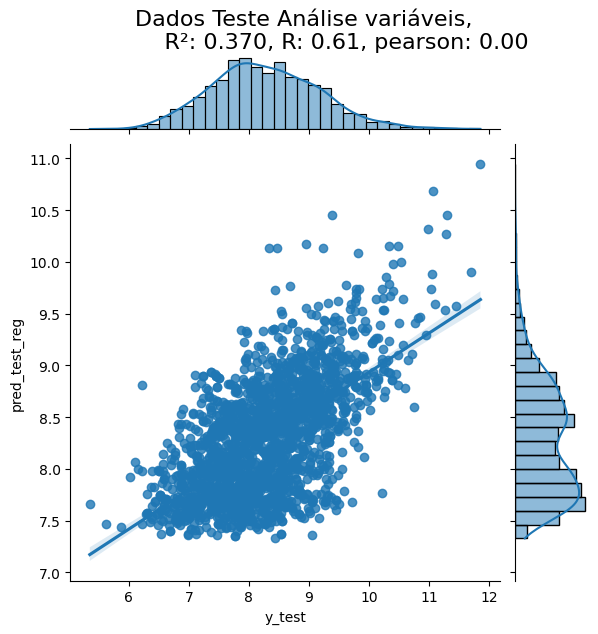

In [83]:
# Plot do conjunto de dados de teste, observado / predito na Regressão
sns.jointplot(
    x="y_test",
    y="pred_test_reg",
    kind="reg",
    data=df_pred_test
)

r_square = r2_score(df_pred_test.y_test, df_pred_test.pred_test_reg)
_, p = pearsonr(df_pred_test.y_test, df_pred_test.pred_test_reg)
title = f'''Análise variáveis,
            R²: {r_square:.3f}, R: {r_square**0.5:.2f}, pearson: {p:.2f}
        '''

plt.suptitle(f"Dados Teste {title}", y=1.05, size=16)
plt.show()

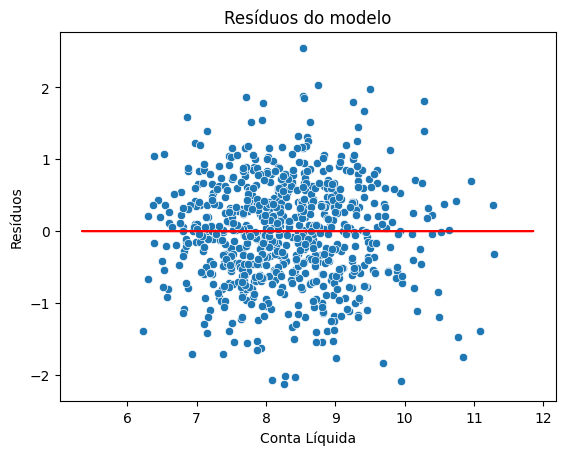

In [84]:
# Analisando os resíduos
x = df_pred_test.y_test
y = regressao_forward.resid
sns.scatterplot(
    x=x,
    y=y,
)

plt.plot(x, [0]*len(x), '-r')

plt.title("Resíduos do modelo")
plt.xlabel("Conta Líquida")
plt.ylabel("Resíduos")
plt.show()

Análise de predição Unitária

In [85]:
def predicao_unitaria(df_test_um: pd.DataFrame) -> tuple:
    colunas_base = [
        "Intercept",
        "C(sexo, Treatment('F'))[T.M]",
        "C(posse_de_veiculo, Treatment(False))[T.True]",
        "C(posse_de_imovel, Treatment(True))[T.False]",
        "C(tipo_renda, Treatment('Assalariado'))[T.Empresário]",
        "C(educacao, Treatment('Secundário'))[T.Superior completo]",
        "C(qt_pessoas_residencia, Treatment(2.0))[T.4.0]",
        "idade",
        "tempo_emprego",
    ]
    valores_true = {
        "C(sexo, Treatment('F'))[T.M]": 'M',
        'C(posse_de_veiculo, Treatment(False))[T.True]': True,
        'C(posse_de_imovel, Treatment(True))[T.False]': False,
        "C(tipo_renda, Treatment('Assalariado'))[T.Empresário]": 'Empresário',
        "C(educacao, Treatment('Secundário'))[T.Superior completo]": 'Superior completo',
        'C(qt_pessoas_residencia, Treatment(2.0))[T.4.0]': '4.0'
    }
    novas_colunas = {v[0]: v[1] for v in zip(df_test_um.columns, colunas_base[1:])}
    df_test_um.rename(columns=novas_colunas, inplace=True)
    index = df_test_um.index
    valores_true = pd.DataFrame(valores_true, index=index)
    df_test_um = df_test_um == valores_true
    df_test_um['Intercept'] = 1.0

    df_test_um[df.columns[7]] = df.loc[index, df.columns[7]].values[0]
    df_test_um[df.columns[8]] = df.loc[index, df.columns[8]].values[0]
    predicao = regressao_forward.predict(df_test_um)
    predicao_index = predicao.index[0]
    predicao_value = np.exp(float(predicao.values[0]))
    return predicao_index, predicao_value

In [87]:
colunas = [1,2,3,5,6,9]
df_test_um = df.iloc[:, colunas].sample(1)

index, predicao = predicao_unitaria(df_test_um=df_test_um)
predicao

4323.708072533928

In [88]:
df.loc[index, "renda"]

4016.38

## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.